In [77]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import build_vae, decode_smiles, generate_structures, my_colors, MoleculeVAE, one_hot, decode_latent, sample

def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))
        
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

In [38]:
#ROUND 1: GDB TRAINING BY THE 100K

#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#training data
df = pd.read_csv('../data/GDB/GDB17.1000000', names=['smiles'])
data_size = 100000
max_data = df.shape[0]
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length)

for p in range(0,10):
    selected = df['smiles'][data_size*p:data_size*(p+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    print(values[0])
    print(values.iloc[-1])
    print(len(values))
    padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
    X_train = np.zeros((data_size, smile_max_length, chars_in_dict), dtype=np.float32)
    
    for i, smile in enumerate(padded_smiles):
        for j, char in enumerate(smile):
            X_train[i, j, char_to_index[char]] = 1
    X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
    chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
    chemvae.save('gen2_2mol_1mil_GDB17_{}.h5'.format(p+1))

CCC(N)C(C)C1(CC#C)CC(CC)N=CN1.CC1=C2N=CC(NCC=O)=C(F)N2C(C=O)=N1
CC1=C2N=CC(NCC=O)=C(F)N2C(C=O)=N1.CCC(N)C(C)C1(CC#C)CC(CC)N=CN1
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2757s 31ms/step - loss: 4.7901 - acc: 0.6336 - val_loss: 4.3106 - val_acc: 0.6578
CC(CN)C1=CN2C(N1)=C(Br)C(N)=C(Br)C2=N.CC12OC3C1C(C=C2)N1CCC2=CSC3=C12
CC12OC3C1C(C=C2)N1CCC2=CSC3=C12.CC(CN)C1=CN2C(N1)=C(Br)C(N)=C(Br)C2=N
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2772s 31ms/step - loss: 4.2467 - acc: 0.6585 - val_loss: 4.1893 - val_acc: 0.6611
CC12COC(=O)N1C1(CS(=O)(=O)NC21C)C=O.CC1C=CCC1NCCCNCC(C)=NO
CC1C=CCC1NCCCNCC(C)=NO.CC12COC(=O)N1C1(CS(=O)(=O)NC21C)C=O
100000
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 2768s 31ms/step - loss: 4.1297 - acc: 0.6635 - val_loss: 4.1782 - val_acc: 0.6604
CC1(C=C2C(O)C3NCC1(C)C23N)

In [3]:
#ROUND 2: GDB TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='gen2_2mol_1mil_GDB17_10.h5')

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        for i, smile in enumerate(padded_smiles):
            for j, char in enumerate(smile):
                X_train[i, j, char_to_index[char]] = 1
        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)

CC1C(=N)N2CC(=O)CN=C2C2CCCC12O.CC1NCC2COC(COCC#C)OC2C1C
CC1NCC2COC(COCC#C)OC2C1C.CC1C(=N)N2CC(=O)CN=C2C2CCCC12O
500000
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14209s 32ms/step - loss: 4.5817 - acc: 0.6447 - val_loss: 4.4509 - val_acc: 0.6547
gen2_2mol_50mil_GDB17_1_1.h5
CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO.CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N
CC1(OC(OC2=C(O)SC=C12)C(O)CN)C#N.CCNC1C2NC(=N)C1C(N)(C(C)N)C2CO
499999
Train on 449999 samples, validate on 50000 samples
Epoch 1/1
449999/449999 [==============================] - 14190s 32ms/step - loss: 4.4024 - acc: 0.6578 - val_loss: 4.3185 - val_acc: 0.6634
gen2_2mol_50mil_GDB17_1_2.h5
CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1.CC1CC2CNCCNCC(CN2)NCCN1
CC1CC2CNCCNCC(CN2)NCCN1.CC1CNCC(CC(N)C2=CC(N)=C(N)O2)C1
500000
Train on 450000 samples, validate on 50000 samples
Epoch 1/1
450000/450000 [==============================] - 14314s 32ms/step - loss: 4.3197 - acc: 0.6644 - val_loss: 4.6631 - val_ac

In [274]:
class MoleculeVAE():

    autoencoder = None
    
    def create(self,
               charset,
               max_length = 105,
               latent_rep_size = 292,
               weights_file = None):
        charset_length = len(charset)
        
        x = Input(shape=(max_length, charset_length))
        _, z = self._buildEncoder(x, latent_rep_size, max_length)
        self.encoder = Model(x, z)

        encoded_input = Input(shape=(latent_rep_size,))
        self.decoder = Model(
            encoded_input,
            self._buildDecoder(
                encoded_input,
                latent_rep_size,
                max_length,
                charset_length
            )
        )

        x1 = Input(shape=(max_length, charset_length))
        vae_loss, z1 = self._buildEncoder(x1, latent_rep_size, max_length)
        self.autoencoder = Model(
            x1,
            self._buildDecoder(
                z1,
                latent_rep_size,
                max_length,
                charset_length
            )
        )

        self.qspr = Model(
            x1,
            self._buildQSPR(
                z1,
                latent_rep_size,
                max_length,
                charset_length
            )
        )

        if weights_file:
            self.autoencoder.load_weights(weights_file, by_name = True)
            self.encoder.load_weights(weights_file, by_name = True)
            self.decoder.load_weights(weights_file, by_name = True)
            self.qspr.load_weights(weights_file, by_name = True)

        self.autoencoder.compile(optimizer = 'Adam',
                                 loss = {'decoded_mean': vae_loss, 'qspr': 'mean_squared_error'},
                                 metrics = ['accuracy', 'mse'])

    def _buildEncoder(self, x, latent_rep_size, max_length, epsilon_std = 0.01):
        h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
        h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
        h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
        h = Flatten(name='flatten_1')(h)
        h = Dense(435, activation = 'relu', name='dense_1')(h)

        def sampling(args):
            z_mean_, z_log_var_ = args
            batch_size = K.shape(z_mean_)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_rep_size), mean=0., stddev = epsilon_std)
            return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

        z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
        z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss

        return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,), name='lambda')([z_mean, z_log_var]))

    def _buildDecoder(self, z, latent_rep_size, max_length, charset_length):
        
        h = Dense(latent_rep_size, name='decoder_input', activation = 'relu')(z)
        h = RepeatVector(max_length, name='repeat_vector')(h)
        h = GRU(501, return_sequences = True, name='gru_1')(h)
        h = GRU(501, return_sequences = True, name='gru_2')(h)
        h = GRU(501, return_sequences = True, name='gru_3')(h)
        smiles_decoded = TimeDistributed(Dense(charset_length, activation='softmax'), name='decoded_mean')(h)
        
        h = Dense(latent_rep_size, name='qspr_input', activation='relu')(z)
        h = Dense(100, activation='relu', name='hl_1')(h)
        h = Dropout(0.5)(h)
        smiles_qspr = Dense(1, activation='linear', name='qspr')(h)
        
        return smiles_decoded, smiles_qspr
    
    def _buildQSPR(self, z, latent_rep_size, max_length, charset_length):
        h = Dense(latent_rep_size, name='latent_input', activation='relu')(z)
        h = Dense(100, activation='relu', name='hl_1')(h)
        h = Dropout(0.5)(h)
        return Dense(1, activation='linear', name='qspr')(h)

    def save(self, filename):
        self.autoencoder.save_weights(filename)
    
    def load(self, charset, weights_file, latent_rep_size = 292):
        self.create(charset, weights_file = weights_file, latent_rep_size = latent_rep_size)

In [13]:
#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_1_2.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

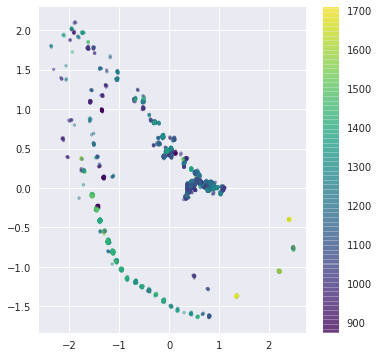

In [19]:
# display a 2D plot of the digit classes in the latent space
#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

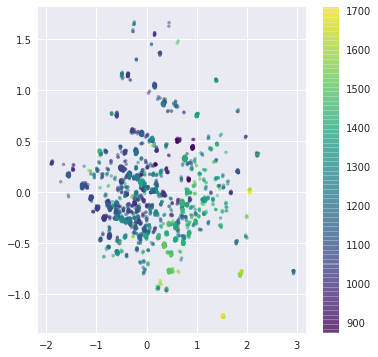

In [159]:
# display a 2D plot of the digit classes in the latent space
#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2_qspr_density_ATP_30_epoch.h5'
# name = 'gen3_2mol_qspr_density_ATP_10_epoch.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [230]:
from scripts import MoleculeVAE

In [207]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

In [208]:
df = pd.read_csv('../data/GDB/GDB17.1000000', names=['smiles'])
selected = df['smiles'][0:100].reset_index(drop=True)
gdbs = pd.Series(selected.values + '.' + selected[::-1].values)

In [249]:
gdbs[0]

'CCC(N)C(C)C1(CC#C)CC(CC)N=CN1.CC1OCC2C1C(C)NC(=O)C(C)=CC2=O'

In [297]:
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_1_1.h5'
# name = 'gen3_2mol_qspr_density_ATP_10_epoch.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

In [305]:
string = ""
for i in chemvae.autoencoder.predict(one_hot(salts[0], char_to_index, smile_max_length=105))[:1]:
    if len(i.shape) > 2:
        i = i[0] #for qspr chemvae there is an extra dim
    for j in i:
#         print(j.shape)
        index = sample(j, temperature=0.5)
        string += index_to_char[index]
string

'33c333/333/333333.33B33333S333333c333333/3373333333222222222222222222222222222222222222222222222222222222'

In [24]:
chemvae.autoencoder.weights

[<tf.Variable 'conv_1_13/kernel:0' shape=(9, 37, 9) dtype=float32_ref>,
 <tf.Variable 'conv_1_13/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'conv_2_13/kernel:0' shape=(9, 9, 9) dtype=float32_ref>,
 <tf.Variable 'conv_2_13/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'conv_3_13/kernel:0' shape=(11, 9, 10) dtype=float32_ref>,
 <tf.Variable 'conv_3_13/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_1_13/kernel:0' shape=(790, 435) dtype=float32_ref>,
 <tf.Variable 'dense_1_13/bias:0' shape=(435,) dtype=float32_ref>,
 <tf.Variable 'z_mean_13/kernel:0' shape=(435, 292) dtype=float32_ref>,
 <tf.Variable 'z_mean_13/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'z_log_var_13/kernel:0' shape=(435, 292) dtype=float32_ref>,
 <tf.Variable 'z_log_var_13/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'decoder_input_13/kernel:0' shape=(292, 292) dtype=float32_ref>,
 <tf.Variable 'decoder_input_13/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'gr

In [51]:
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)
chemvae.autoencoder.weights

[<tf.Variable 'conv_1_19/kernel:0' shape=(9, 37, 9) dtype=float32_ref>,
 <tf.Variable 'conv_1_19/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'conv_2_19/kernel:0' shape=(9, 9, 9) dtype=float32_ref>,
 <tf.Variable 'conv_2_19/bias:0' shape=(9,) dtype=float32_ref>,
 <tf.Variable 'conv_3_19/kernel:0' shape=(11, 9, 10) dtype=float32_ref>,
 <tf.Variable 'conv_3_19/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_1_19/kernel:0' shape=(790, 435) dtype=float32_ref>,
 <tf.Variable 'dense_1_19/bias:0' shape=(435,) dtype=float32_ref>,
 <tf.Variable 'z_mean_19/kernel:0' shape=(435, 292) dtype=float32_ref>,
 <tf.Variable 'z_mean_19/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'z_log_var_19/kernel:0' shape=(435, 292) dtype=float32_ref>,
 <tf.Variable 'z_log_var_19/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'decoder_input_19/kernel:0' shape=(292, 292) dtype=float32_ref>,
 <tf.Variable 'decoder_input_19/bias:0' shape=(292,) dtype=float32_ref>,
 <tf.Variable 'gr

In [47]:
chemvae.autoencoder.weights[-2][0][0]

<tf.Tensor 'strided_slice_21:0' shape=() dtype=float32>

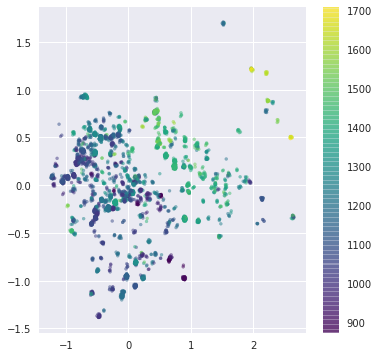

In [22]:
# display a 2D plot of the digit classes in the latent space
#training data
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2_qspr_density_ATP_30_epoch.h5'
name = 'gen3_2mol_qspr_density_ATP_10_epoch.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

z_test = chemvae.encoder.predict(X_train)
pca = PCA(n_components=2)
pcs = pca.fit_transform(z_test)
plt.figure(figsize=(6, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [21]:
chemvae.qspr.predict(X_train)

array([[0.08661762],
       [0.09376382],
       [0.07859061],
       ...,
       [0.0877149 ],
       [0.09973271],
       [0.07593167]], dtype=float32)

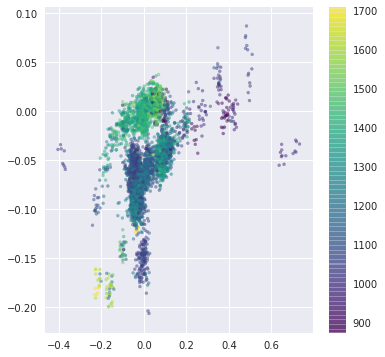

In [14]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

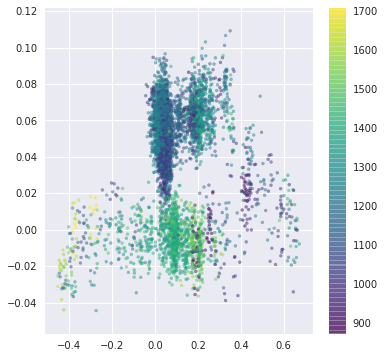

In [12]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [17]:
salts.unique().shape

(462,)

In [5]:
properties = ['density']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
props = properties
devmodel = salty.aggregate_data(props, T=T, P=P, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
salts = devmodel.Data['smiles_string']
salts = salts.reset_index(drop=True)
print(salts.shape)

(5631,)


In [6]:
values = salts
print(values[0])
print(values.iloc[-1])
print(len(values))
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
X_train = np.zeros((values.shape[0], smile_max_length, chars_in_dict), dtype=np.float32)
Y_train = np.array(devmodel.Data['Specific density, kg/m<SUP>3</SUP>'])
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

CCCC[n+]1ccc(cc1)C.[B-](F)(F)(F)F
C1=C[N+](CCCC)=CN1C.C(C(F)(F)F)(C(F)(F)S(=O)(=O)[O-])F
5631


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42) 

In [9]:
chemvae.autoencoder.fit(X_train, [X_train, Y_train],
                        shuffle = False,
                        validation_data=(X_test, [X_test, Y_test]),
                        epochs=30)
chemvae.save('gen2_2mol_50mil_GDB17_5_2_qspr_density_ATP_30_epoch.h5')

Train on 5067 samples, validate on 564 samples
Epoch 1/30
5067/5067 [==============================] - 178s 35ms/step - loss: 5.8884 - decoded_mean_loss: 4.2846 - qspr_loss: 1.6037 - decoded_mean_acc: 0.6920 - decoded_mean_mean_squared_error: 0.0102 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 1.6037 - val_loss: 3.6676 - val_decoded_mean_loss: 3.6247 - val_qspr_loss: 0.0429 - val_decoded_mean_acc: 0.7180 - val_decoded_mean_mean_squared_error: 0.0090 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.0429
Epoch 2/30
5067/5067 [==============================] - 178s 35ms/step - loss: 4.8522 - decoded_mean_loss: 3.4199 - qspr_loss: 1.4323 - decoded_mean_acc: 0.7217 - decoded_mean_mean_squared_error: 0.0087 - qspr_acc: 0.0000e+00 - qspr_mean_squared_error: 1.4323 - val_loss: 3.7417 - val_decoded_mean_loss: 3.2212 - val_qspr_loss: 0.5205 - val_decoded_mean_acc: 0.7342 - val_decoded_mean_mean_squared_error: 0.0083 - val_qspr_acc: 0.0000e+00 - val_qspr_mean_squared_error: 0.5205

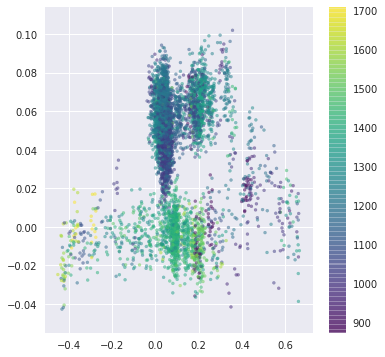

In [10]:
# display a 2D plot of the digit classes in the latent space
z_test = chemvae.encoder.predict(X_train)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.exp(Y_train),
            alpha=.5, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [17]:
#ROUND 3: MIX TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
name = 'gen2_2mol_50mil_GDB17_5_2.h5'
chemvae.create(char_set, max_length=smile_max_length, weights_file=name)

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        
        salts_added = 0
        for i, smile in enumerate(padded_smiles):
            #randomly select salt or GDB
            linearly_scaled_prob = random.random() < i/data_epoch_size
            if linearly_scaled_prob:
                salts_added += 1
                smile = random.choice(salts)
            for j, char in enumerate(smile[:102]):
                X_train[i, j, char_to_index[char]] = 1
        print("salts added: {}".format(salts_added))

        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_num_mix_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)

In [17]:
#ROUND 4: SALT TRAINING BY THE 500K

#training array info
smile_max_length = 105
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())

#chars needed for 2 mol w/ anions
char_to_index['.'] = 33
char_to_index['@'] = 34
char_to_index['e'] = 35
char_to_index['/'] = 36

char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)

#initialize weights
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='2mol_50mil_GDB17_3.h5')

for p in range(0,5):
    #in this trianing we skip the firt 1Mil GDB since
    #we trained on this already in 100K increments, (p+2)
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p+2))
    df.columns = ['smiles']
    data_epoch_size = 500000 #500K
    for _epoch in range(2):
        selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
        values = pd.Series(selected.values + '.' + selected[::-1].values)
        print(values[0])
        print(values.iloc[-1])
        print(len(values))
        padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]
        X_train = np.zeros((len(values), smile_max_length, chars_in_dict), dtype=np.float32)
        
        salts_added = 0
        for i, smile in enumerate(padded_smiles):
            #randomly select salt or GDB
#             linearly_scaled_prob = random.random() < i/data_epoch_size
#             if linearly_scaled_prob:
            salts_added += 1
            smile = random.choice(salts)
            for j, char in enumerate(smile[:102]):
                X_train[i, j, char_to_index[char]] = 1
        print("salts added: {}".format(salts_added))

        X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
        chemvae.autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))
        name = 'gen2_2mol_50mil_GDB17_num_mix_num_cat_{}_{}.h5'.format(p+1,_epoch+1)
        print(name)
        chemvae.save(name)

In [ ]:
for p in range(1,2):
    df = pd.read_csv('../data/GDB/GDB17.{}000000'.format(p))
    df.columns = ['smiles']
    selected = df['smiles'][data_size*p:data_size*(p+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)
    padded_smiles =  [pad_smiles(i, smile_max_length) for i in values 
                      if pad_smiles(i, smile_max_length)]
    X_train = np.zeros((data_size, smile_max_length, chars_in_dict), dtype=np.float32)
    
    
    for i, smile in enumerate(padded_smiles):
        #randomly select salt or GDB
#         linearly_scaled_prob = random.random() < i/data_size
#         if linearly_scaled_prob:
        smile = random.choice(salts)
        for j, char in enumerate(smile[:102]):
            X_train[i, j, char_to_index[char]] = 1
    X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=42) 
    chemvae.autoencoder.fit(X_train, X_train, shuffle = False,
                            validation_data=(X_test, X_test), epochs=1000)
    chemvae.save('2mol_50mil_GDB17_3_1mil_mix_1mil_cat_{}.h5'.format(p))

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 51s 57ms/step - loss: 6.2026 - acc: 0.5413 - val_loss: 6.2432 - val_acc: 0.3029
Epoch 2/1000
900/900 [==============================] - 56s 62ms/step - loss: 5.8525 - acc: 0.1342 - val_loss: 6.0067 - val_acc: 0.1347
Epoch 3/1000
900/900 [==============================] - 52s 58ms/step - loss: 5.6952 - acc: 0.1242 - val_loss: 5.8408 - val_acc: 0.1493
Epoch 4/1000
900/900 [==============================] - 53s 59ms/step - loss: 5.6696 - acc: 0.1252 - val_loss: 5.8560 - val_acc: 0.1376
Epoch 5/1000
900/900 [==============================] - 55s 61ms/step - loss: 5.5961 - acc: 0.1253 - val_loss: 5.7788 - val_acc: 0.1425
Epoch 6/1000
900/900 [==============================] - 53s 59ms/step - loss: 5.5347 - acc: 0.1277 - val_loss: 5.7247 - val_acc: 0.1440
Epoch 7/1000
900/900 [==============================] - 56s 62ms/step - loss: 5.4862 - acc: 0.1276 - val_loss: 5.6977 - val_acc: 0.1458
Ep

In [5]:
values = df['smiles'][:data_size]
print(values.shape)

(500000,)


In [6]:
del df

In [8]:
smile_max_length = values.map(len).max()
print(smile_max_length)

51


(array([1.0000000e+00, 6.0000000e+00, 6.3700000e+02, 1.4796200e+05,
        6.6722430e+06, 2.9969172e+07, 1.2690346e+07, 5.0860600e+05,
        1.0870000e+04, 1.5700000e+02]),
 array([ 2. ,  6.9, 11.8, 16.7, 21.6, 26.5, 31.4, 36.3, 41.2, 46.1, 51. ]),
 <a list of 10 Patch objects>)

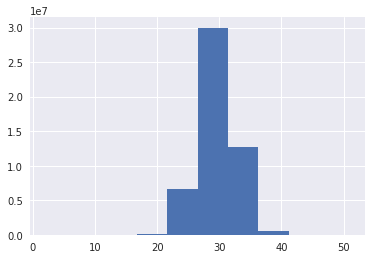

In [6]:
plt.hist(values.map(len))

In [9]:
def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))

In [10]:
### randomize training
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]

In [11]:
shuffle(padded_smiles)

In [100]:
two_component_smiles = [one + padded_smiles[-index] for index, one in enumerate(padded_smiles)]

In [101]:
two_component_smiles[:10]

['BrC1=C2OC(=N)C3=NC=CN3CC2=NC(=N)O1                 BrC1=C2OC(=N)C3=NC=CN3CC2=NC(=N)O1                 ',
 'C1OC2C3=C(NC1C21CC=CC1)OC=N3                       C1CC11N=C2C=CCCN2C2=C1N=NS2                        ',
 'BrC1=CN=C2COC(COC2=C1C=O)OC=N                      C1OCC2=C(SN=C2O1)N1CCCCN=C1                        ',
 'BrC1=CN(C2CCC(NC2)C#C)C(=O)NC1=N                   BrC1=NC=NN2C(=N)C(COC=N)=C(Br)C=C12                ',
 'C1C2OCC3=CNC(N3)=NC3=C(C=NN3)C12                   C1C=CC23OCC=CC4N(C5=C2N=NN5)C134                   ',
 'CC12C3C(C=CCC13O)C1=COC(=N)N21                     C1NCC23OC2C2(CC13)NCC1OCOC21                       ',
 'C1NC2=NC1C#CCC1=CC(CCC1)C2                         BrC1=CC(=O)NC2=C1C(=O)S(=O)(=O)NC=N2               ',
 'BrC1=CN=C(CCC2=CNN=NC2=N)C=C1Br                    BrC1=NC2=C(COC2OC2=CC=NO2)C(Br)=C1                 ',
 'C1OC2=NCC3C=CCC4=C(C=NO4)C123                      CC12C3C1C1(CCCC1C2=NO)NC3C#C                       ',
 'CC12C3C4CC1N=CNC2(C#N)C(=N)N34     

In [12]:
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

In [13]:
char_set = set()
char_set = create_char_list(char_set, padded_smiles)

In [14]:
print(len(char_set))
char_set

31


{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'S',
 '[',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [15]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)
print(cations.shape)

(276,)


In [16]:
padded_smiles_2 =  [pad_smiles(i, smile_max_length) for i in cations if pad_smiles(i, smile_max_length)]

In [17]:
char_set_2 = set()
char_set_2 = create_char_list(char_set_2, padded_smiles_2)

In [18]:
char_set.update(set(char_set_2))

In [19]:
char_set

{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [124]:
char_list = list(char_set)
chars_in_dict = len(char_list)
char_to_index = dict((c, i) for i, c in enumerate(char_list))
index_to_char = dict((i, c) for i, c in enumerate(char_list))

In [328]:
# # save model input
# import json
# json = json.dumps(char_to_index)
# f = open("1mil_GDB17.json","w")
# f.write(json)
# f.close()

In [98]:
# if loading previous model
smile_max_length = 51
# two component model
smile_max_length = 102
import json
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
index_to_char = dict((i, c) for i, c in enumerate(char_list))
chars_in_dict = len(char_list)

In [14]:
X_train = np.zeros((data_size, smile_max_length, chars_in_dict), dtype=np.float32)
X_train.shape

(500000, 102, 33)

In [32]:
# for each i, randomly select whether to sample from GDB or cations (padded_smiles_2)
for i, smile in enumerate(padded_smiles[:data_size]):
#     linearly_scaled_prob = random.random() < i/data_size
#     if linearly_scaled_prob:
    smile = random.choice(cations)
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [15]:
# for two component
for i, smile in enumerate(two_component_smiles[:data_size]):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [340]:
for i, smile in enumerate(padded_smiles[:data_size]):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [16]:
X_train, X_test = train_test_split(X_train, test_size=0.33, random_state=42)

In [17]:
X_train[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
X_train.shape

(335000, 102, 33)

In [20]:
del two_component_smiles

In [19]:
# build special X_train that contains 50% bootstrapped cation data

In [37]:
# need to build RNN to encode. some issues include what the 'embedded dimension' is (vector length of embedded sequence)

so some keras version stuff. 1.0 uses keras.losses to store its loss functions. 2.0 uses objectives. we'll just have to be consistent

In [64]:
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

Here I've adapted the exact architecture used in the [paper](https://github.com/maxhodak/keras-molecules/blob/master/molecules/model.py)

In [106]:
def Encoder(x, latent_rep_size, smile_max_length, epsilon_std = 0.01):
    h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
    h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
    h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
    h = Flatten(name = 'flatten_1')(h)
    h = Dense(435, activation = 'relu', name = 'dense_1')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_rep_size),
                                  mean=0., stddev = epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

    z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
    z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = smile_max_length * binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - \
                                 K.exp(z_log_var), axis = -1)
        return xent_loss + kl_loss

    return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,),
                             name='lambda')([z_mean, z_log_var]))

def Decoder(z, latent_rep_size, smile_max_length, charset_length):
    h = Dense(latent_rep_size, name='latent_input', activation = 'relu')(z)
    h = RepeatVector(smile_max_length, name='repeat_vector')(h)
    h = GRU(501, return_sequences = True, name='gru_1')(h)
    h = GRU(501, return_sequences = True, name='gru_2')(h)
    h = GRU(501, return_sequences = True, name='gru_3')(h)
    return TimeDistributed(Dense(charset_length, activation='softmax'),
                           name='decoded_mean')(h)

In [107]:
x = Input(shape=(smile_max_length, len(char_set)))

In [108]:
_, z = Encoder(x, latent_rep_size=292, smile_max_length=smile_max_length)

In [109]:
encoder = Model(x, z)

encoded_input looks like a dummy layer here:

In [110]:
encoded_input = Input(shape=(292,))

In [111]:
decoder = Model(encoded_input, Decoder(encoded_input, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

create a separate autoencoder model that combines the encoder and decoder (I guess the former cells are for accessing those separate parts of the model)

In [112]:
x1 = Input(shape=(smile_max_length, len(char_set)), name='input_1')

In [113]:
vae_loss, z1 = Encoder(x1, latent_rep_size=292, smile_max_length=smile_max_length)

In [114]:
autoencoder = Model(x1, Decoder(z1, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

we compile and fit

In [115]:
autoencoder.compile(optimizer='Adam', loss=vae_loss, metrics =['accuracy'])

In [44]:
autoencoder.fit(X_train, X_train, shuffle = False, validation_data=(X_test, X_test))

Train on 335000 samples, validate on 165000 samples
Epoch 1/1
335000/335000 [==============================] - 11144s 33ms/step - loss: 4.5784 - acc: 0.6789 - val_loss: 3.8361 - val_acc: 0.7225


In [116]:
autoencoder.load_weights = Out[44]

In [54]:
#trained on 1million GDB17 molecules
autoencoder.save("1Mil_GDB17.h5")

In [97]:
#trained on 500K GDB17 molecules that have been doubled
autoencoder.save("../data/two_predictor_500K_GDB17.h5")

In [345]:
#trained on 1million GDB17 molecules, 50/50 split of 500K GDB17/cation molecules, 500K cation molecules
autoencoder.save("1Mil_GDB17_split_500k_cation_500k.h5")

In [51]:
#trained on 1million cation molecules
autoencoder.save("Bootstrap_1Mil_Cation_1.h5")

In [318]:
#trained on 250K cation molecules
autoencoder.save("Bootstrap_250k_Cation_1.h5")

In [75]:
autoencoder.load_weights("../data/1Mil_GDB17_split_500k.h5")

In [121]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
#     print(dist)
    return np.random.choice(choices, p=dist)

In [122]:
# smi = values[29]
smi = two_component_smiles[0] #cations[0]
print(smi)

BrC1=C2OC(=N)C3=NC=CN3CC2=NC(=N)O1                 BrC1=C2OC(=N)C3=NC=CN3CC2=NC(=N)O1                 


In [123]:
test_smi = smi
# test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1

In [140]:
string = ""
for i in autoencoder.predict(Z):
#     print(i.shape)
#     print('')
    for j in i:
#         print(j.shape)
#         print(j)
        index = sample(j, temperature=1)
        string += index_to_char[index]
#         print(string)
print("\n callback guess: " + string)


 callback guess: B)s4+C2]4N\l)cSoo44PnrCcICNP+nN-s7[1\B\S4SBI6FH614[F=8)o\2]c6Coc[3)3\S55oCc\-nS4S774s-8r67+N \s(rNs386


In [35]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
print(cations.shape)

(276,)


In [36]:
cations = cations.reset_index(drop=True)

In [37]:
test_smi = cations[100]
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1
test_smi

'OCCCCCC([n+]1ccn(c1)C)                             '

In [38]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: 2o21 226227422 22]44333333c#S41S\#SICCs+SSF1P(SS+SS


Alright. So now I'm going to loop through our 276 cations, sample 100x from the decoder based on these representations, and see how many sanitize with the RDKit

In [369]:
cation_samples = []
for smi_index, smi in enumerate(cations):
    smi = pad_smiles(smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
    for t, char in enumerate(smi):
        Z[0, t, char_to_index[char]] = 1
    string = ""
    for i in autoencoder.predict(Z):
        for j in i:
            index = sample(j, temperature=0.5)
            string += index_to_char[index]
    cation_samples.append(string)

In [370]:
print('sampled cations: {}'.format(len(cation_samples)))
print('unique samples: {}'.format(pd.DataFrame(cation_samples).drop_duplicates().shape[0]))

sampled cations: 276
unique samples: 276


In [371]:
cation_samples[:10]

['CCCC1C+]CcccccC))CN                                ',
 'CCCn(C([C+]CCCC)C                                  ',
 'CCCCn1cC[nC]Cc1CCO                                 ',
 'CCCC(=O)N+]1(CCCC     C                            ',
 'CCCOC[CHC]CCCCCC=CCC   C                           ',
 'C21CC=CC=C2[N+]13C(C)(C=C(N1CCCCC)C)               ',
 'C2=CC=CCCC2[C+]1=C(C)(C=C(N1CNCC=C))O              ',
 'C(1CCCCCCCCP+C(CCCCCC)NCCCCCC)  C C     C          ',
 'CCCCCCCCn1Cc[n+]Cc1)C                              ',
 'CCCCnCCO[C+]C(C)N                                  ']

In [372]:
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw

In [373]:
def get_sim(vae_cat):
    scores = []
    for exp_cat in cations:
        ms = [vae_cat, Chem.MolFromSmiles(exp_cat)]
        fps = [FingerprintMols.FingerprintMol(x) for x in ms]
        score = DataStructs.FingerprintSimilarity(fps[0], fps[1])
        scores.append(score)
    return max(scores), scores.index(max(scores))

[N+](CCC(CC)(C)(CCC))C                             
CC[N+](CC)(CC)CCCCCCCC                             
CC1cC[n+](c1)CCCCCCCC                              
CCCCCCC(=C)CC1CCCCOOOC1            N               
C1=C[N+](CCC#C)=CN1CCCCCC                          
Cc1cc([n+](C1c2ccccc2)C)C                          
CCCCCC[C+](CCCCCO)(CCCCCC)CCCCCCC                  
C#CCCC1cc[C+](c1)CCN                               
CCCCCCC[n+]1cc[C](c1)CC                            
CCCCCCC[n+]1cc(C)ccc1                              
CCCCCC[n+]1cccc(C#N)c1                             
C1=C[N+](CCCC)=NN1C                                
CCNC[P+](CCCC)(CCCC)CCCC                           
CC1cc[C+](C1C)CCCCC                                
CCCCCCCCCCC[n+]1ccC(c1)C                           
CCCCC2CCCCC2CC[N+](CC)(CC)CC                       
[P+](CC)(CC)CCCC(CCCCCC)                           
C[N+]1(CCCC1)CC(C)(C)                              
C[N+]1(CCCCC1)CCO                                  
[P+](CC)(CO)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CC[C+](CC)(CC)CCCC                                 
C1=C[N+](C)CC(N)C1CCCOC                            


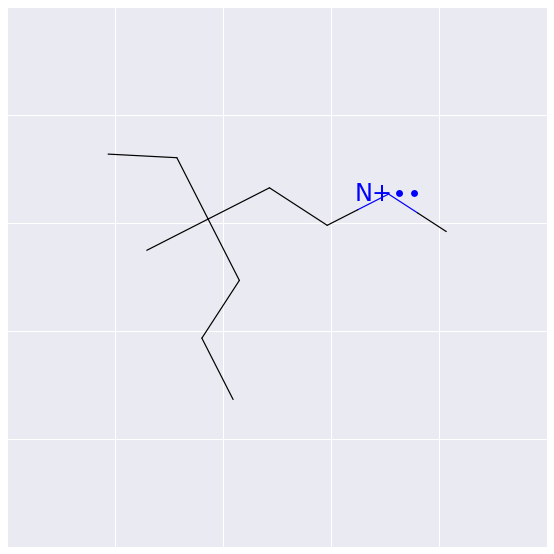

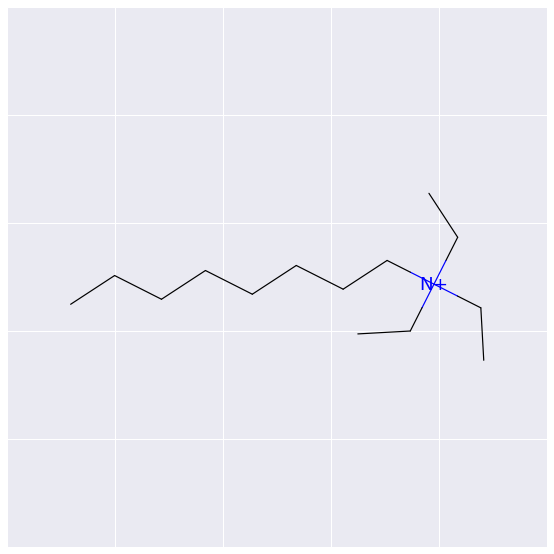

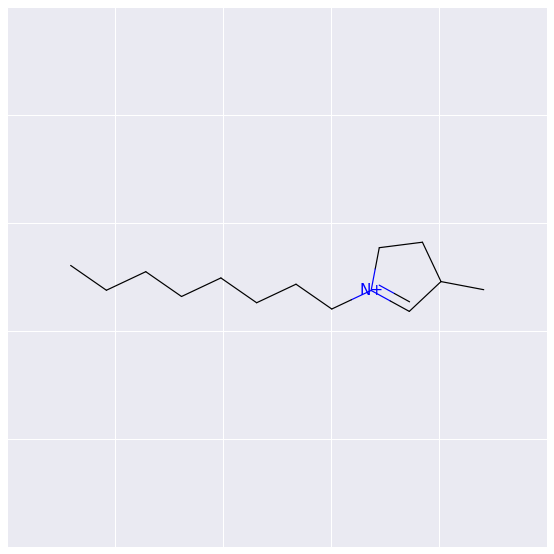

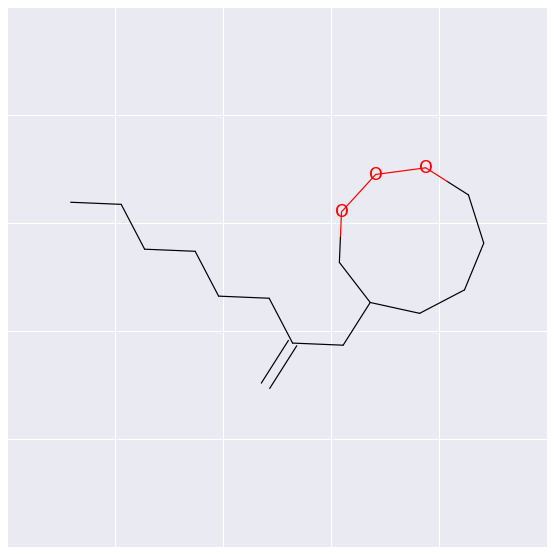

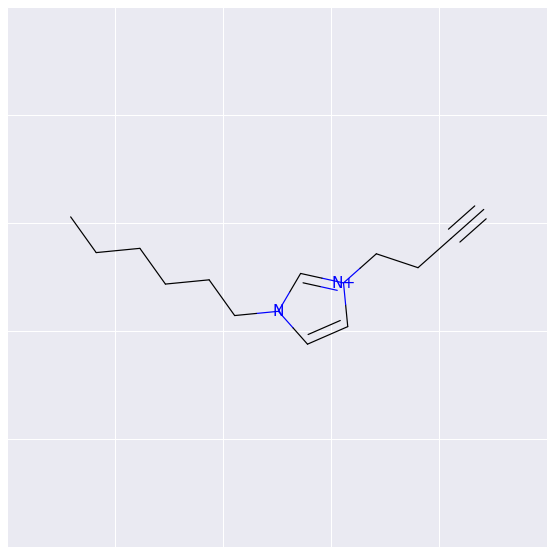

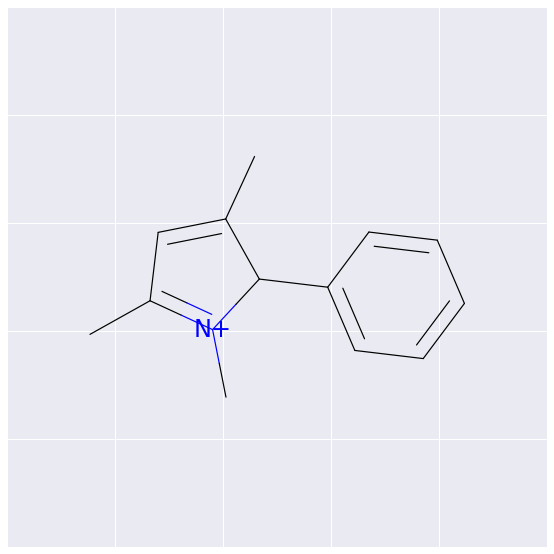

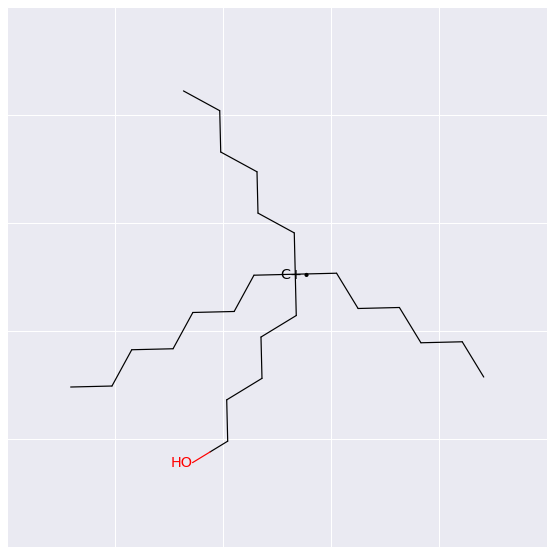

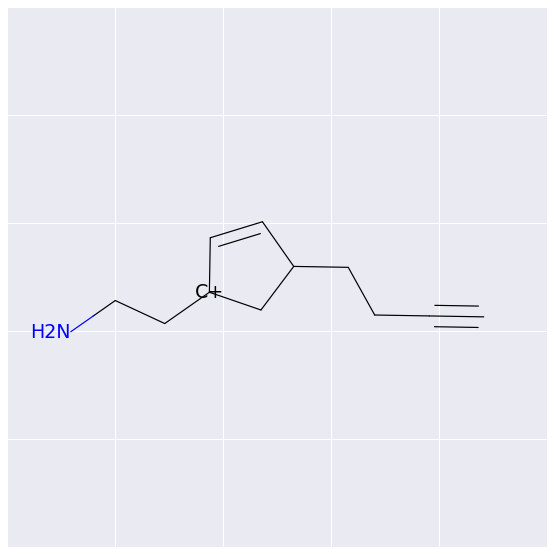

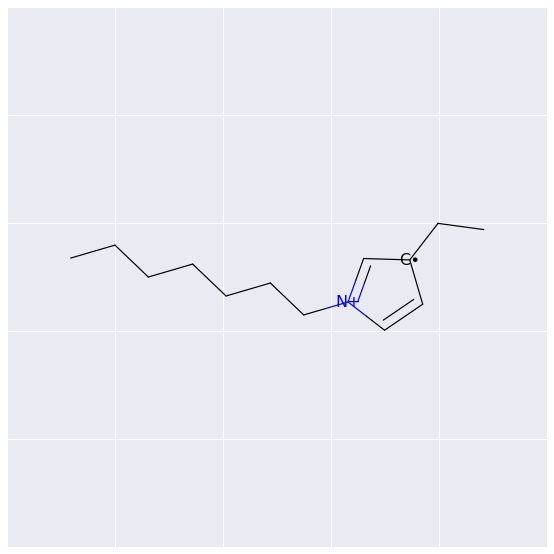

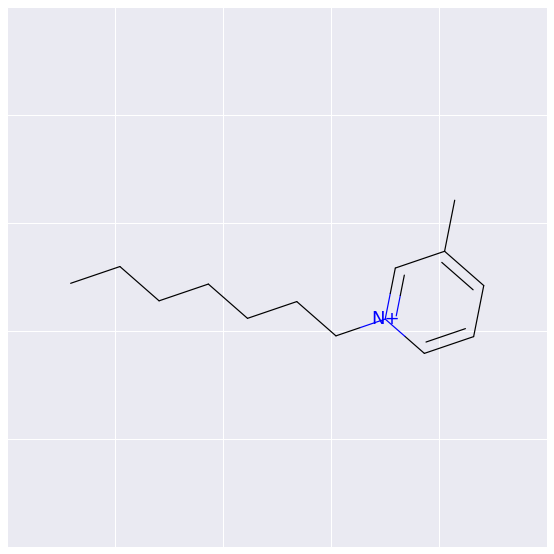

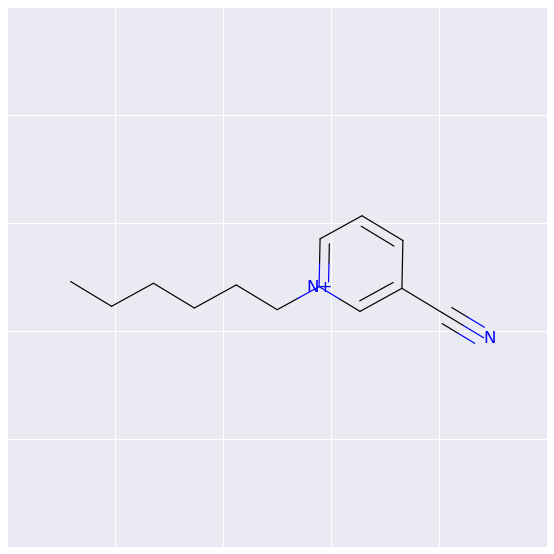

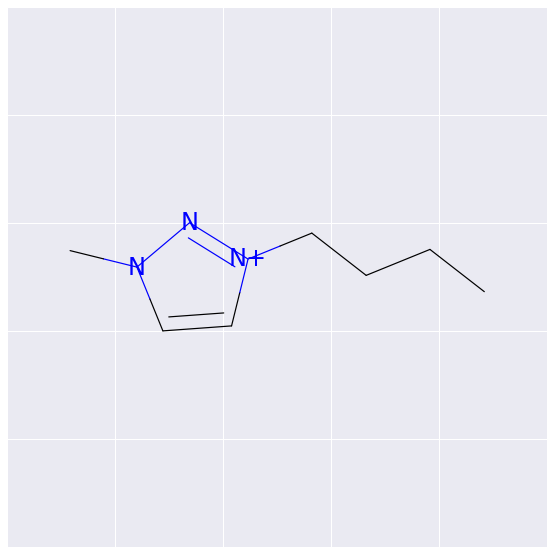

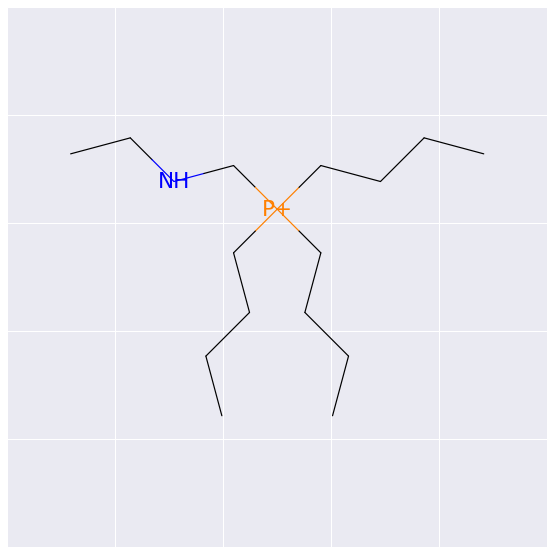

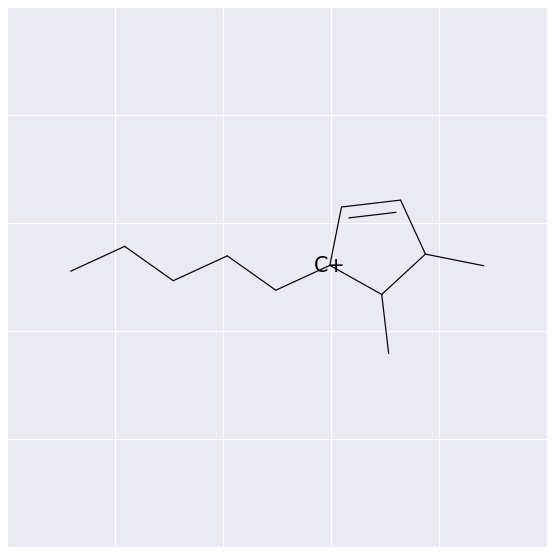

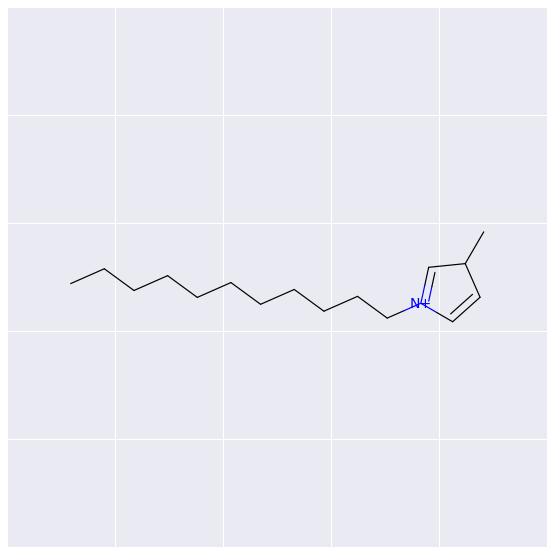

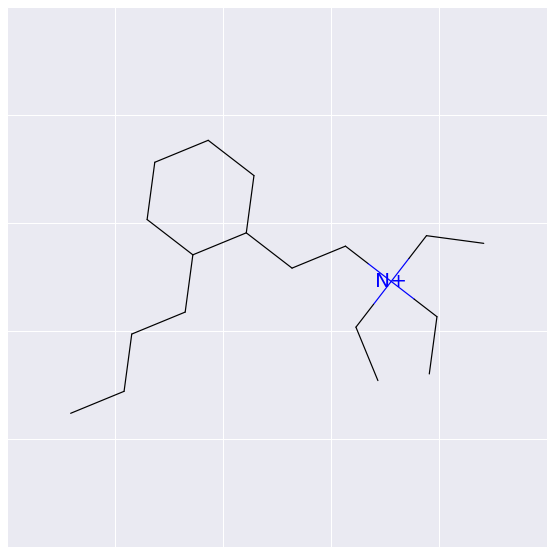

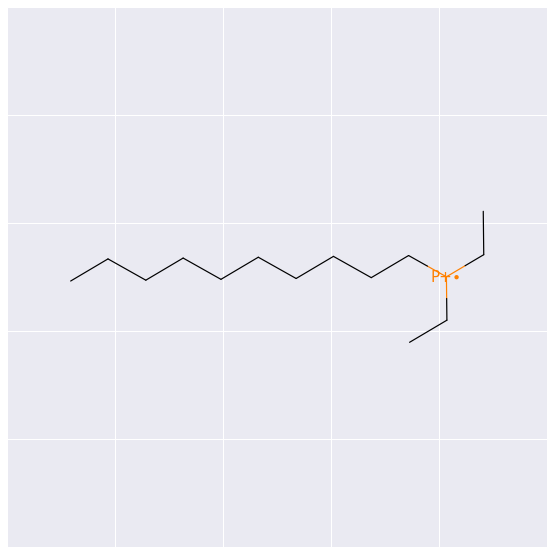

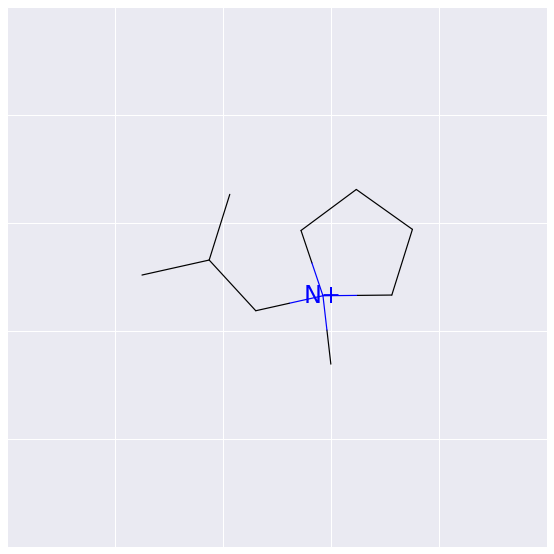

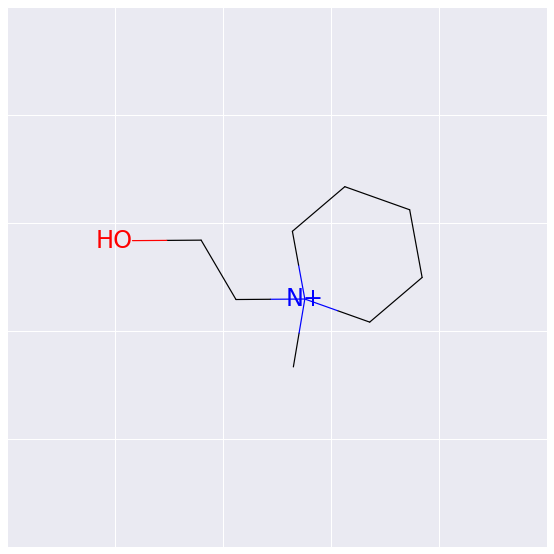

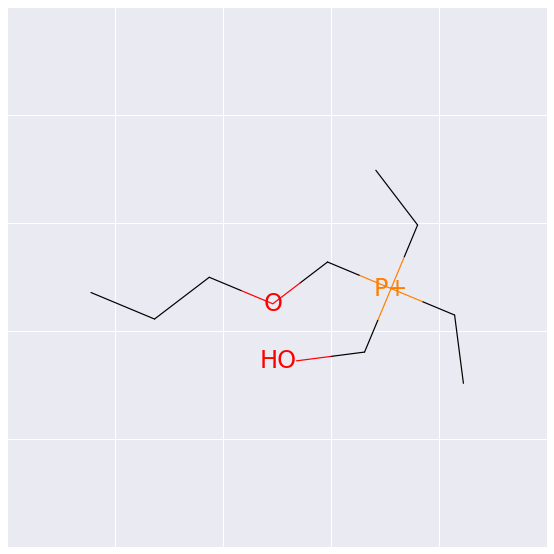

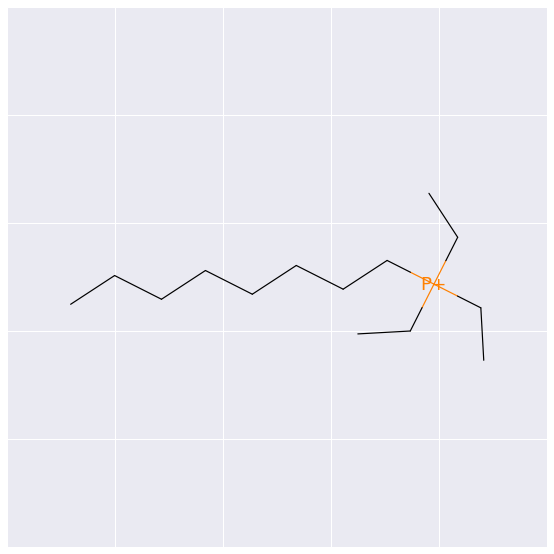

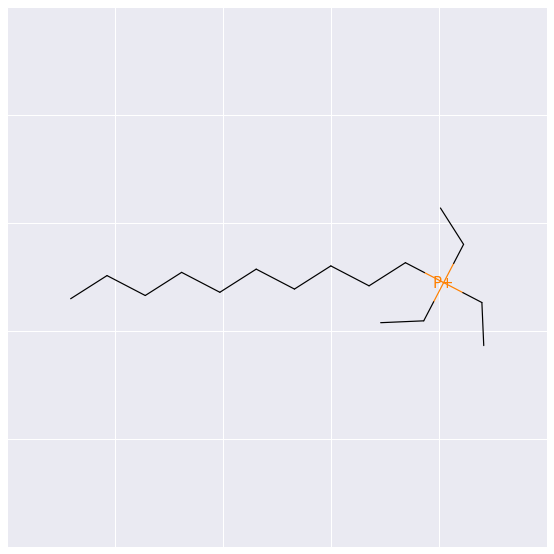

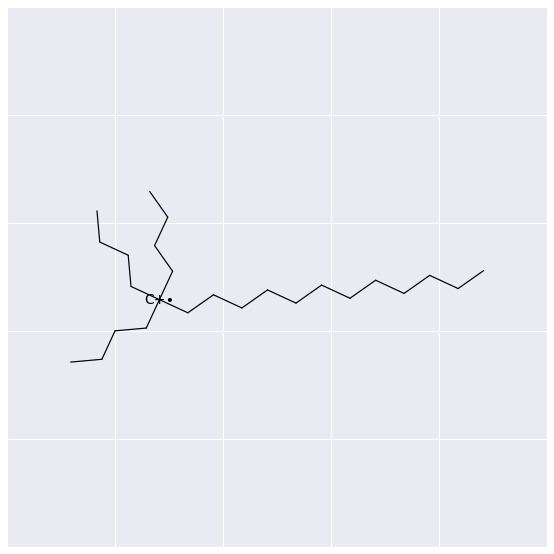

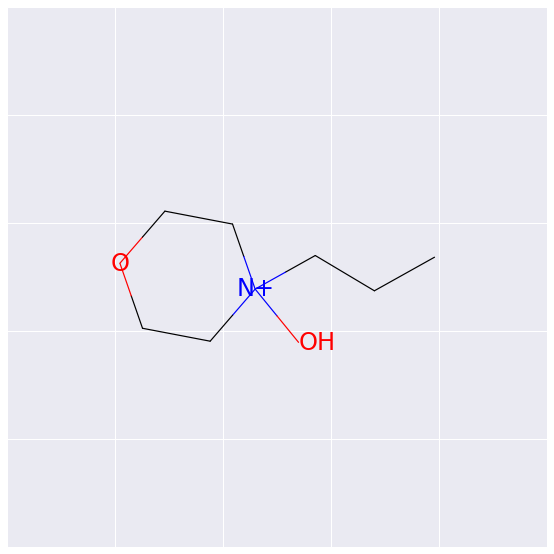

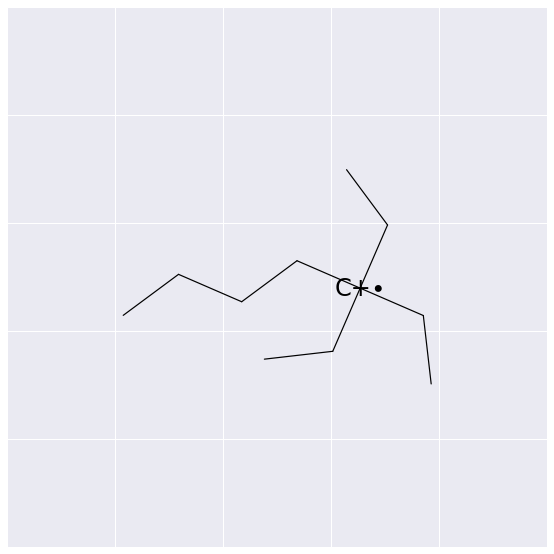

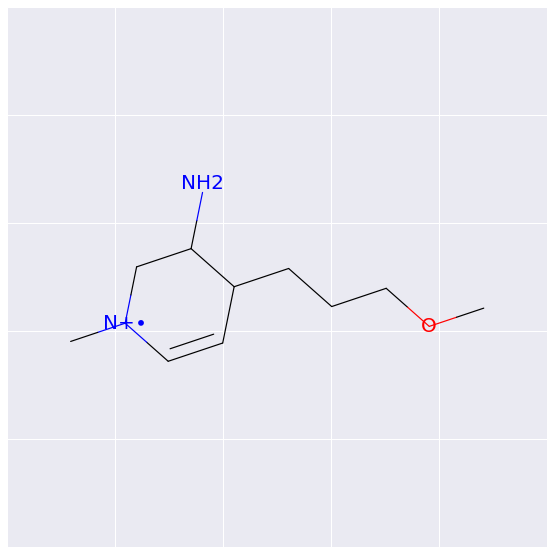

In [374]:
% matplotlib inline
rdkit_mols=[]
for smi in cation_samples:
    try:
        sampled = Chem.MolFromSmiles(smi)
        Draw.MolToMPL(sampled)
        rdkit_mols.append(smi)
        print(smi)
    except:
        pass

0.5434782608695652
1.0
0.5729166666666666
0.5
0.9090909090909091
0.532258064516129
0.46808510638297873
0.5166666666666667
0.5079365079365079
1.0


/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.0
0.5238095238095238
0.6666666666666666
0.5084745762711864
0.5161290322580645
0.7283950617283951
0.890625
1.0
0.872093023255814
0.8243243243243243
1.0
1.0
0.4222222222222222
0.6370967741935484
0.509090909090909
0.545


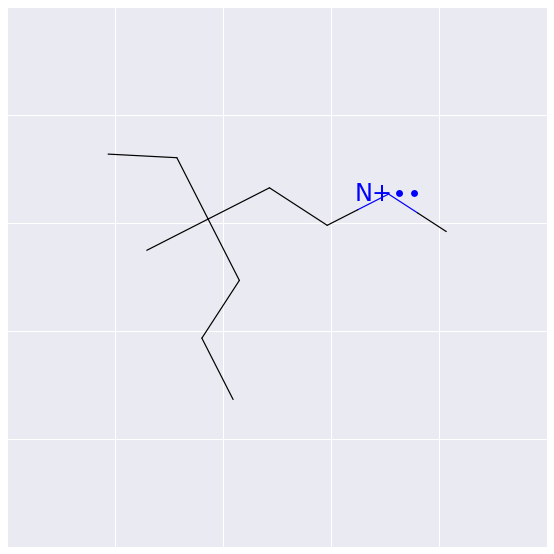

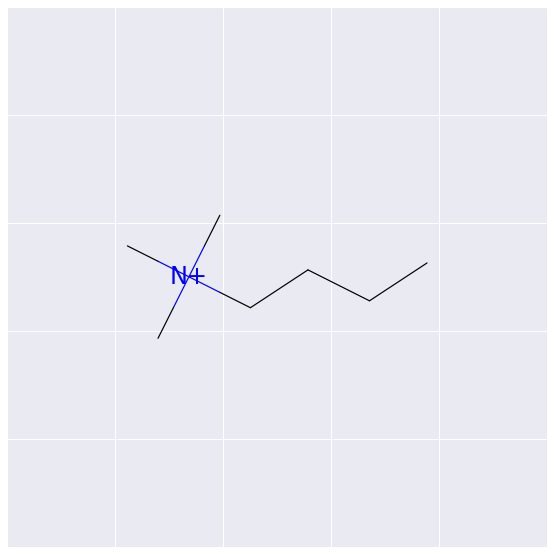

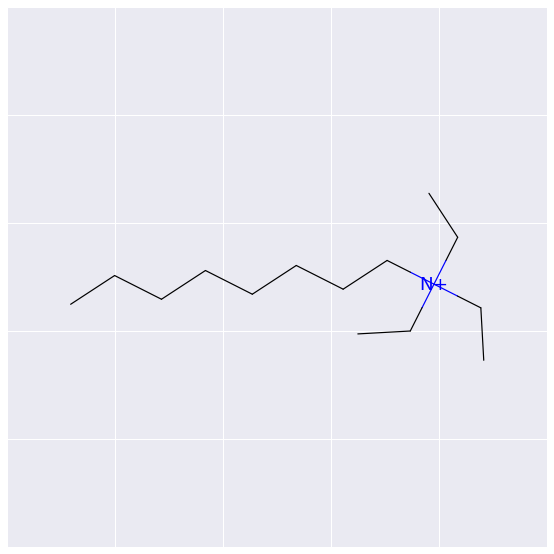

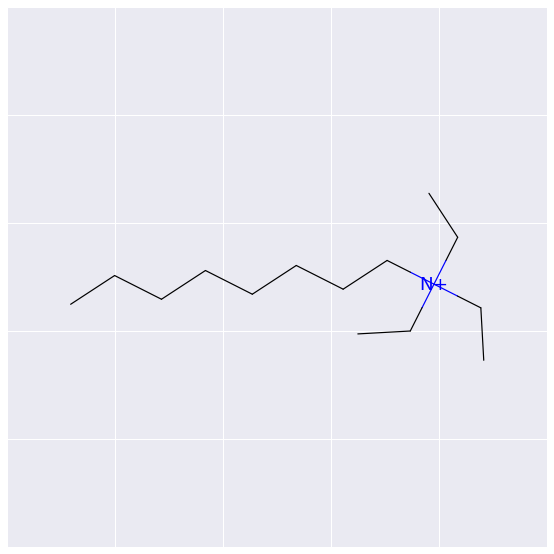

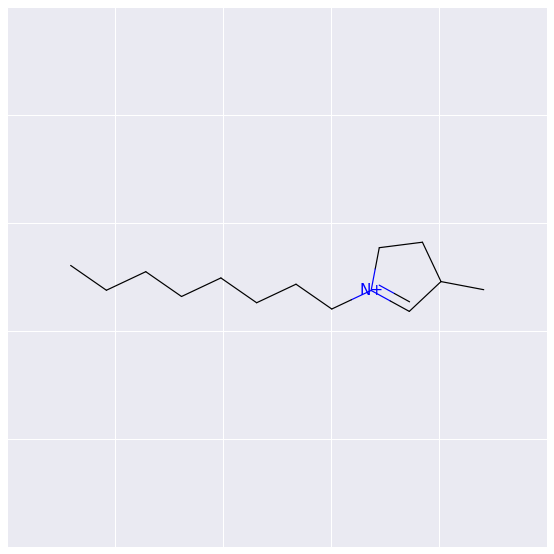

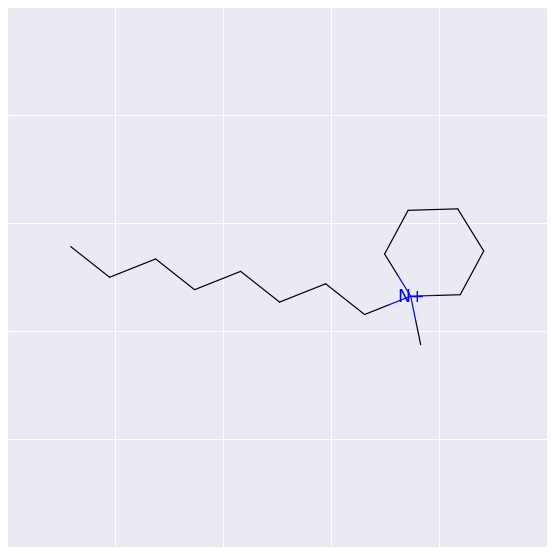

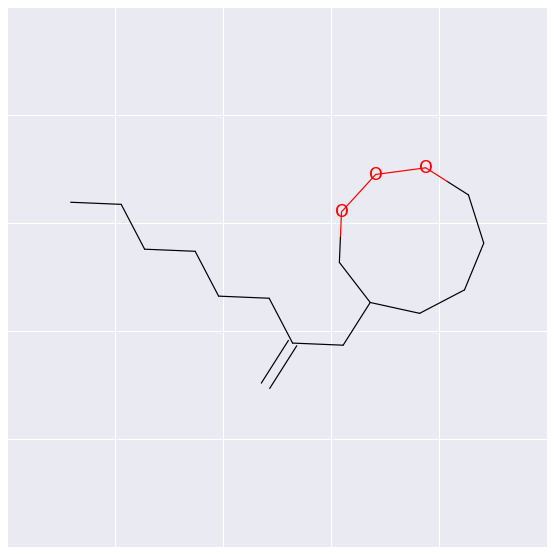

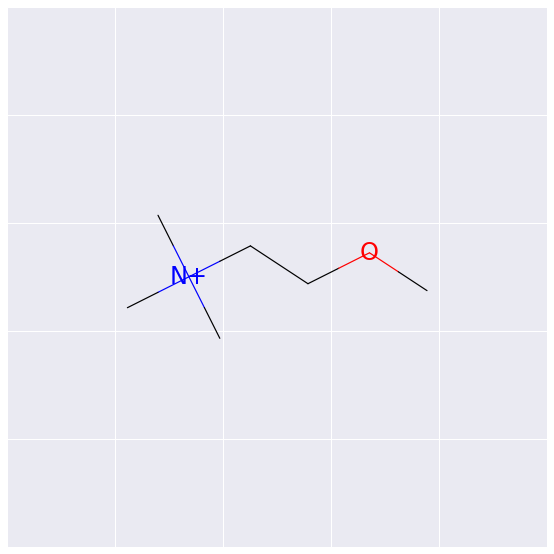

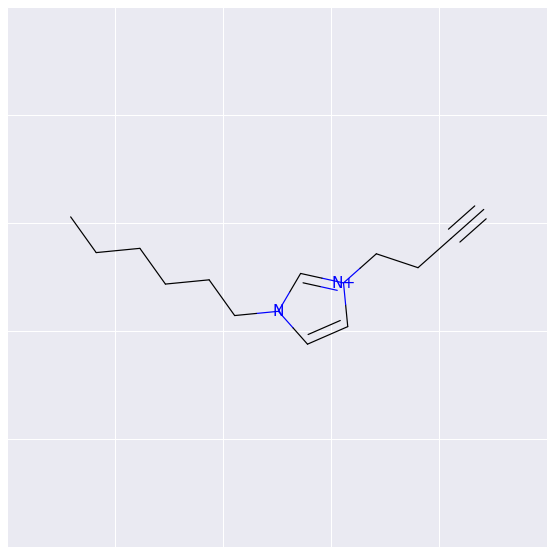

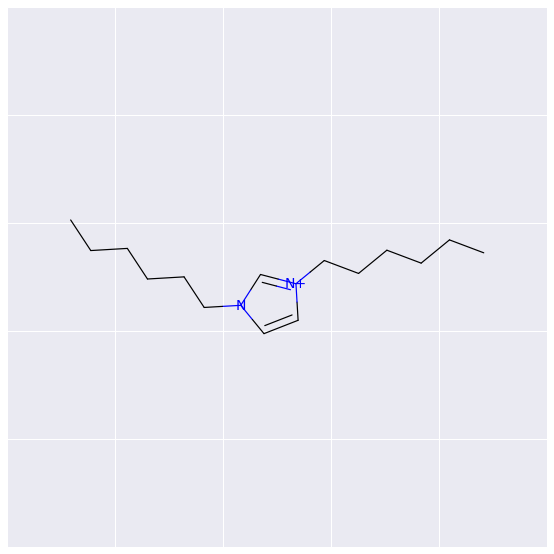

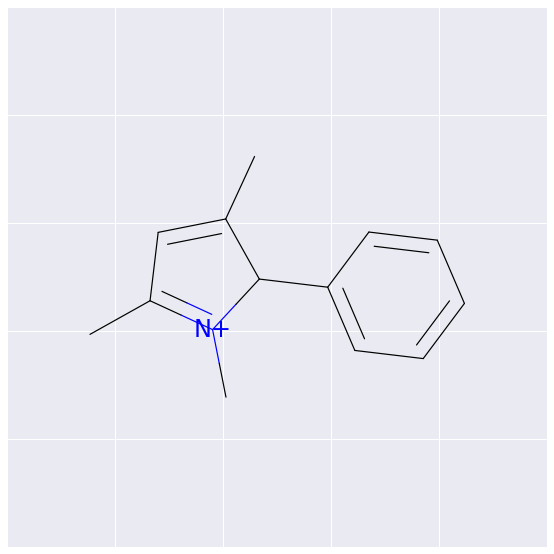

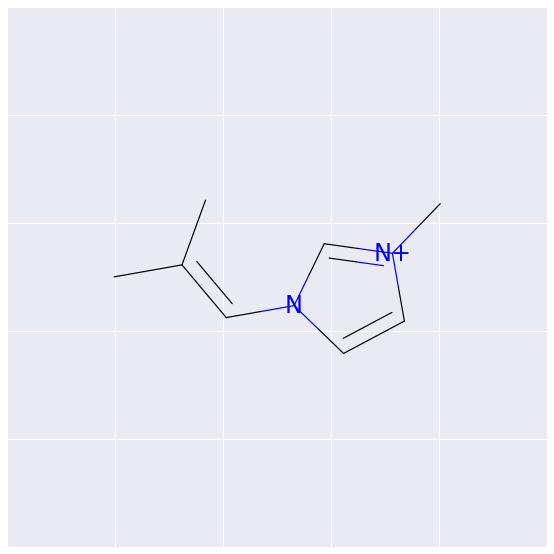

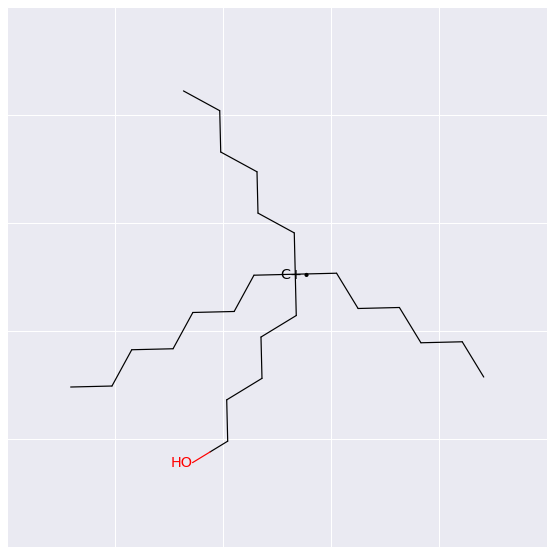

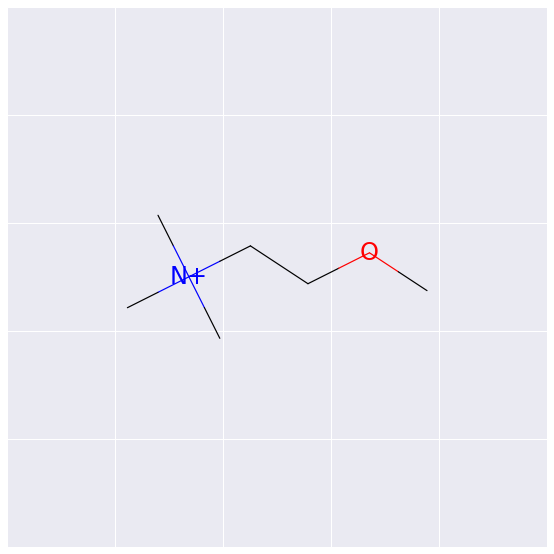

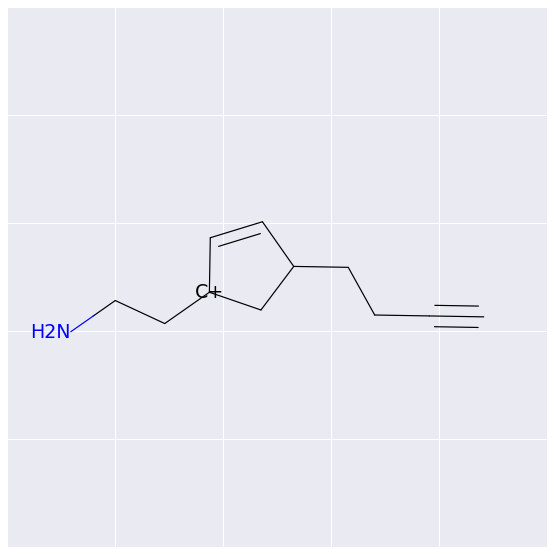

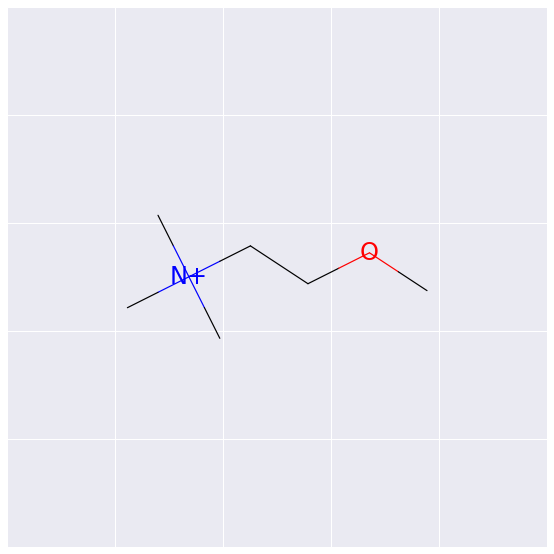

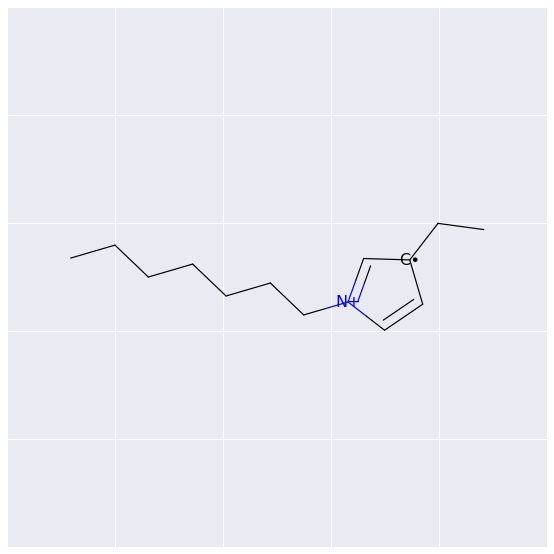

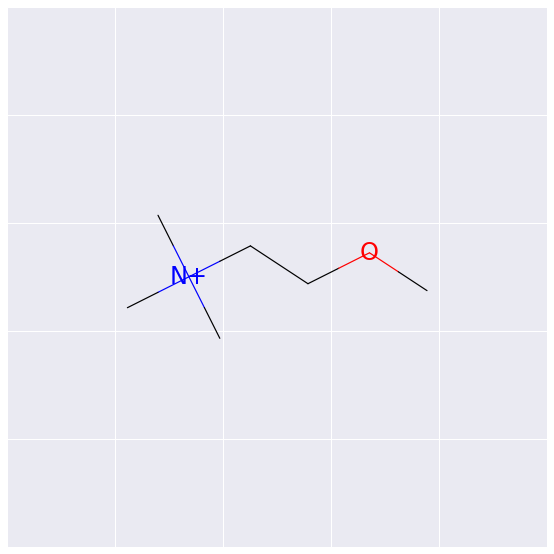

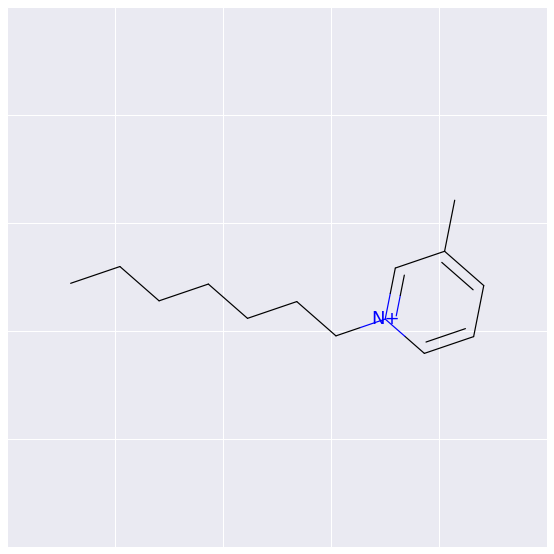

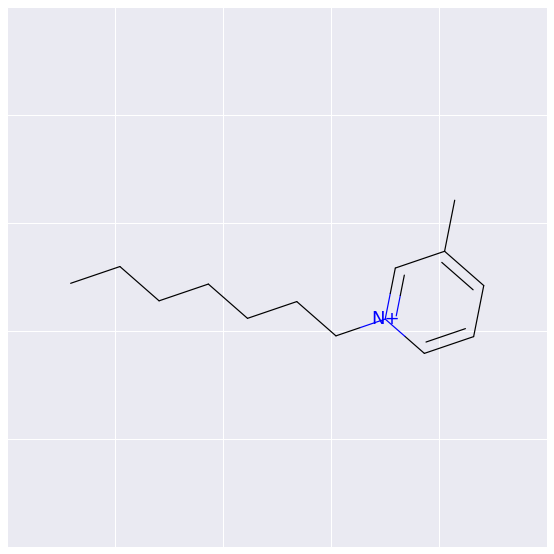

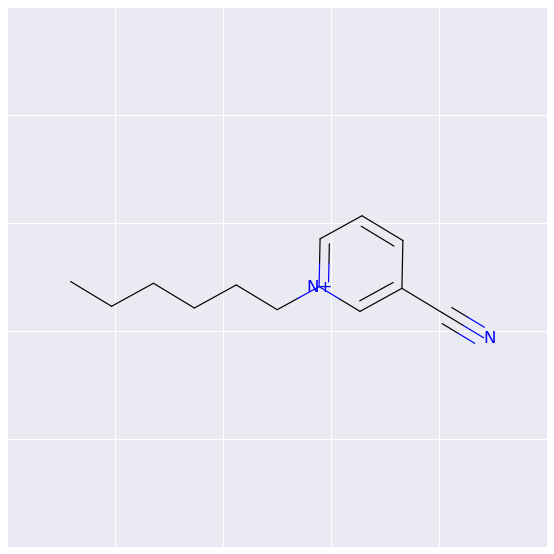

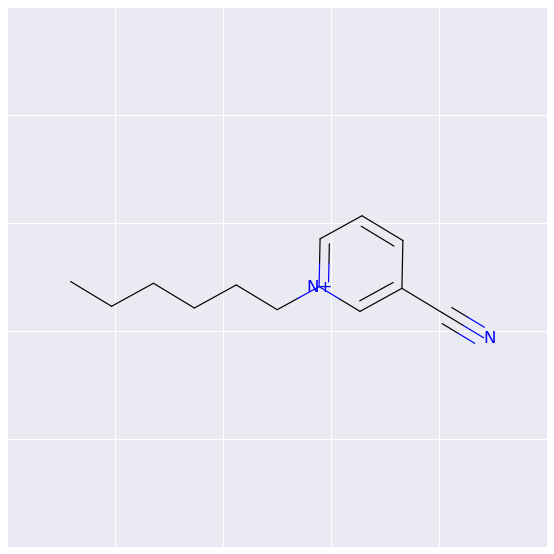

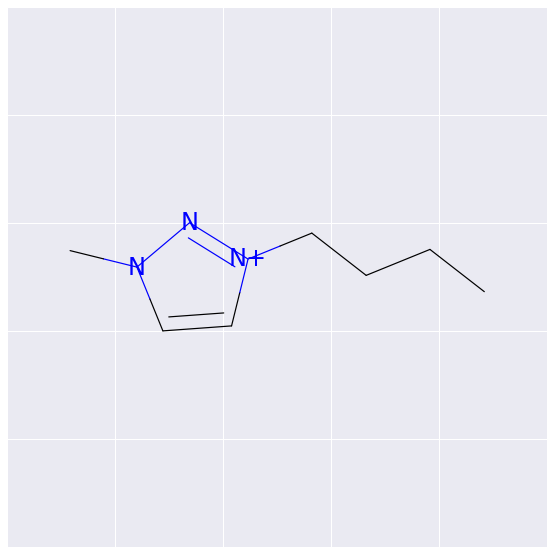

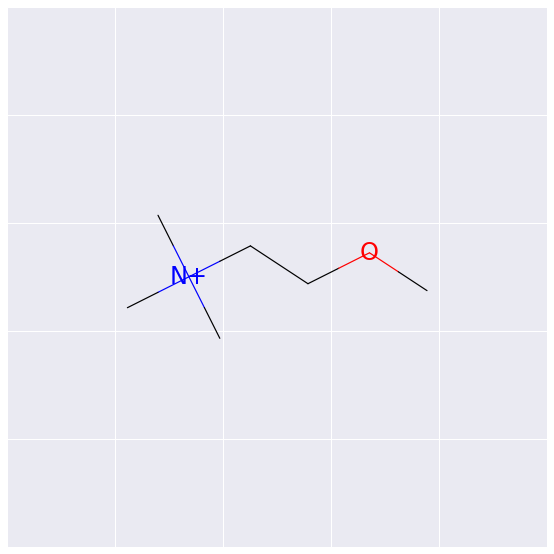

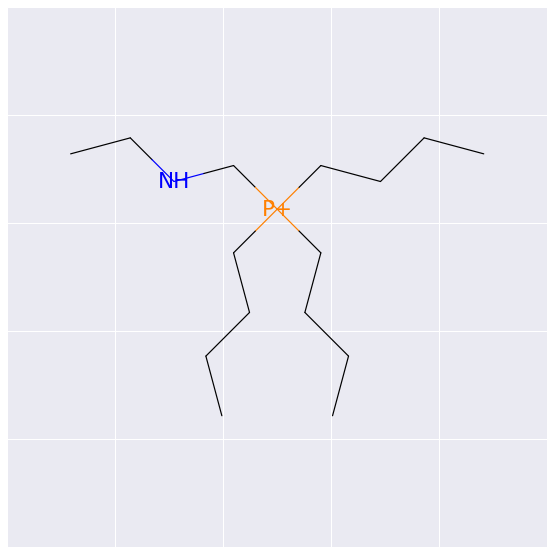

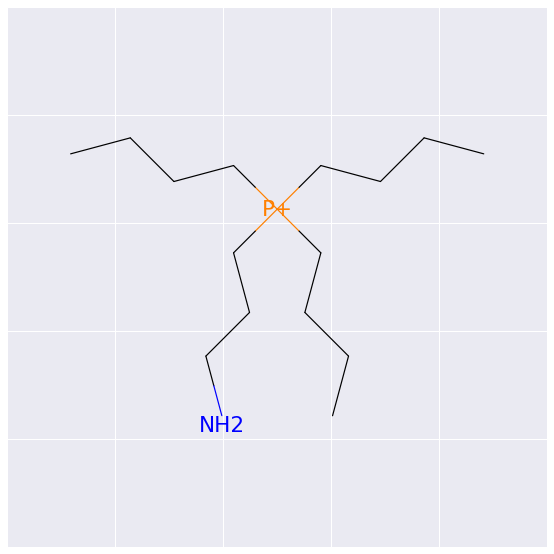

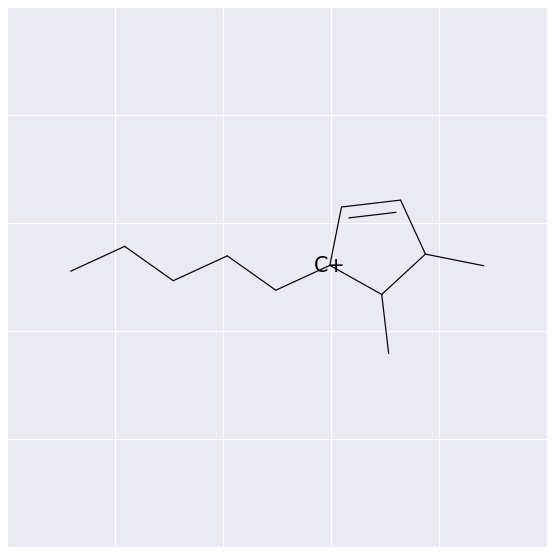

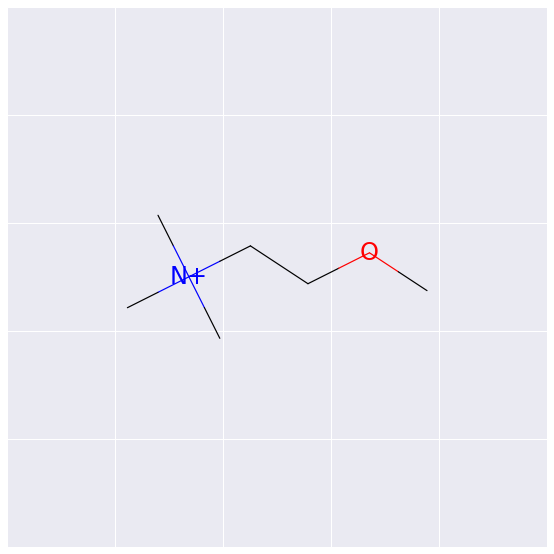

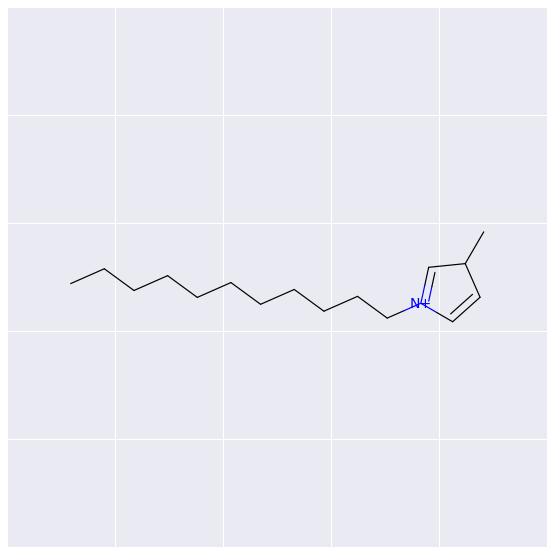

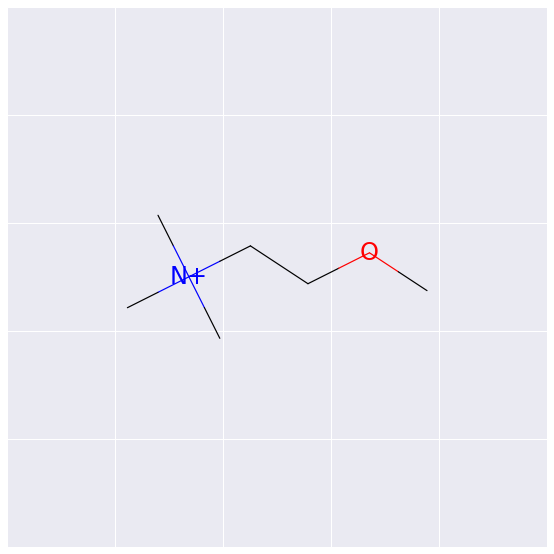

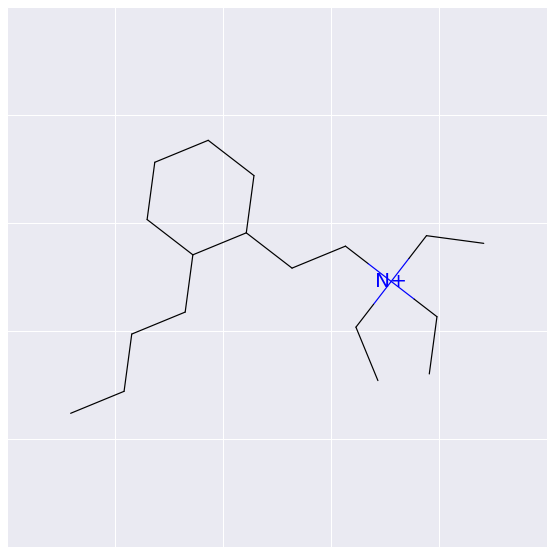

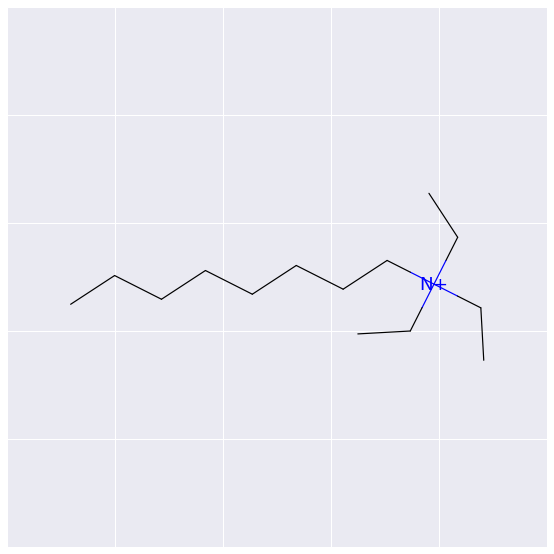

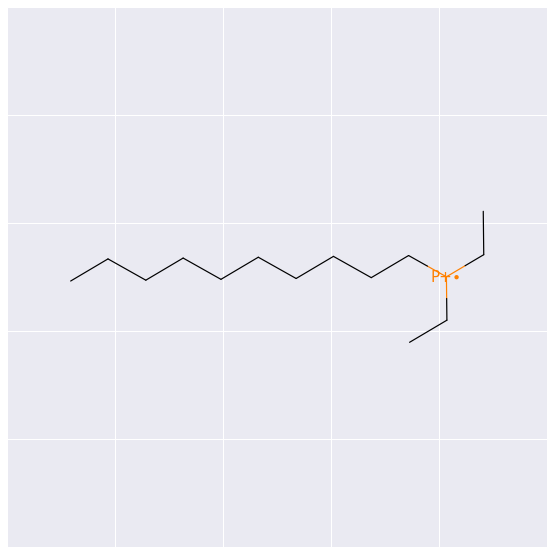

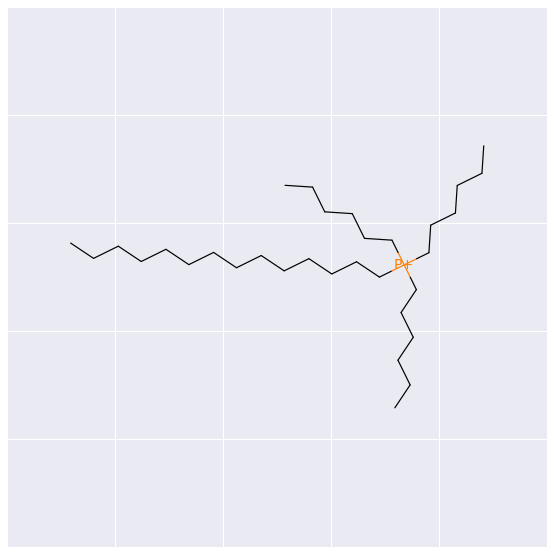

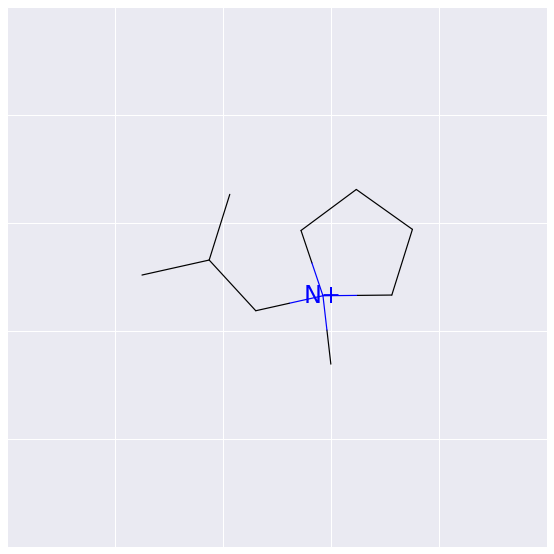

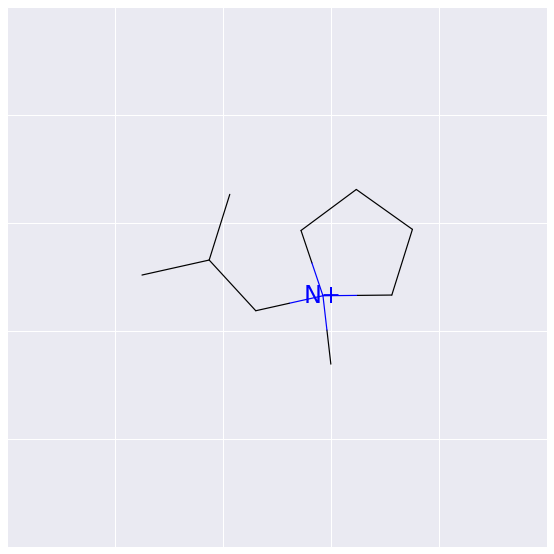

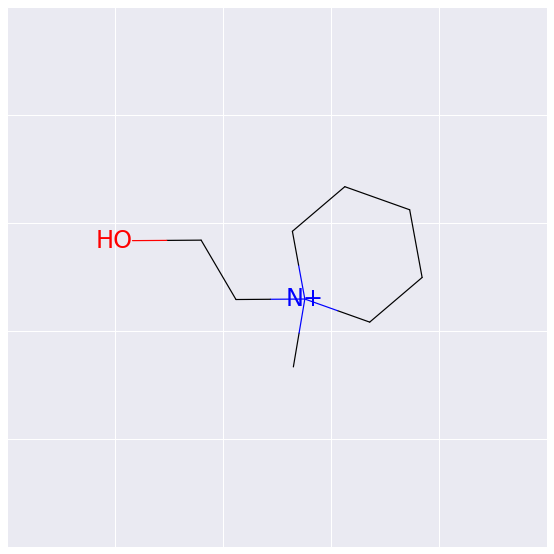

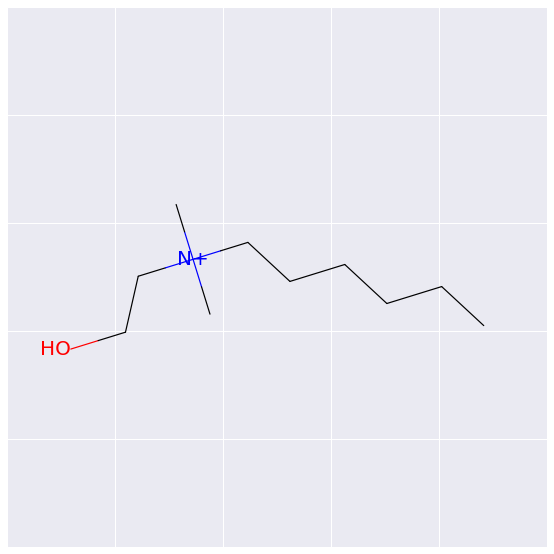

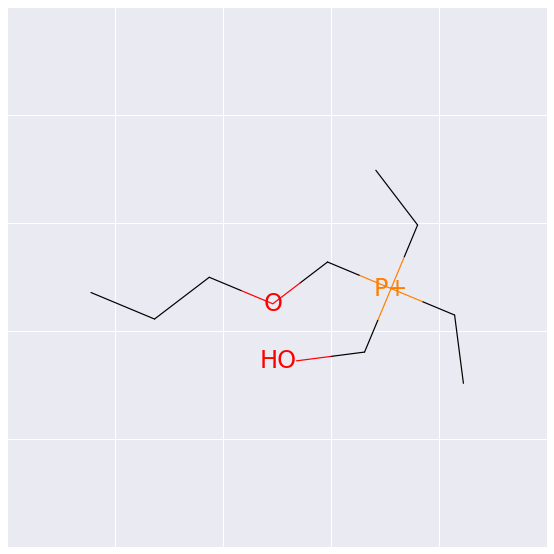

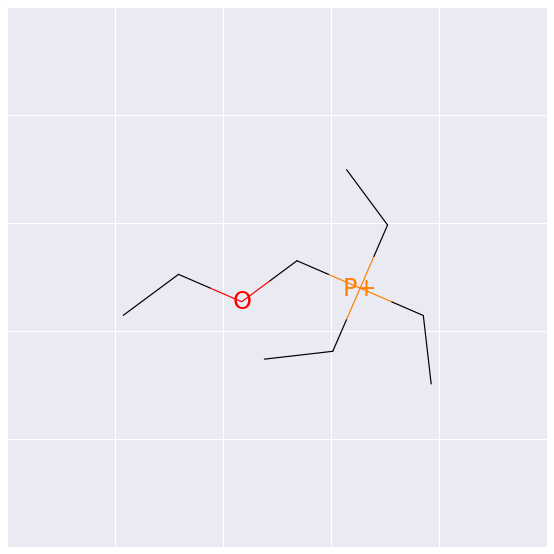

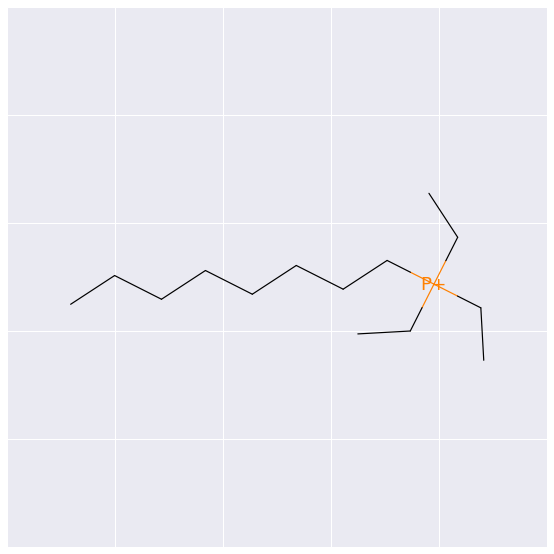

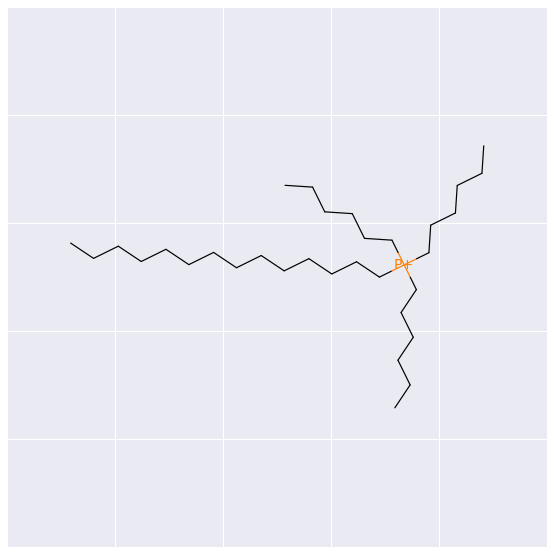

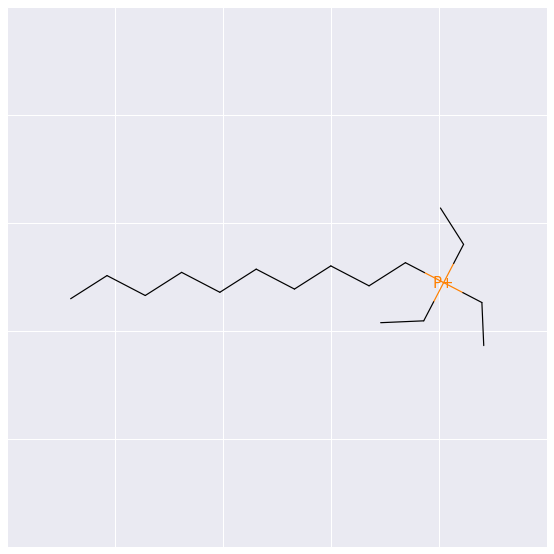

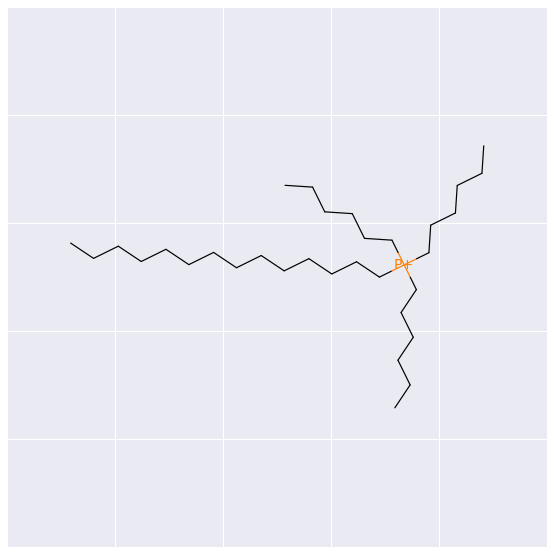

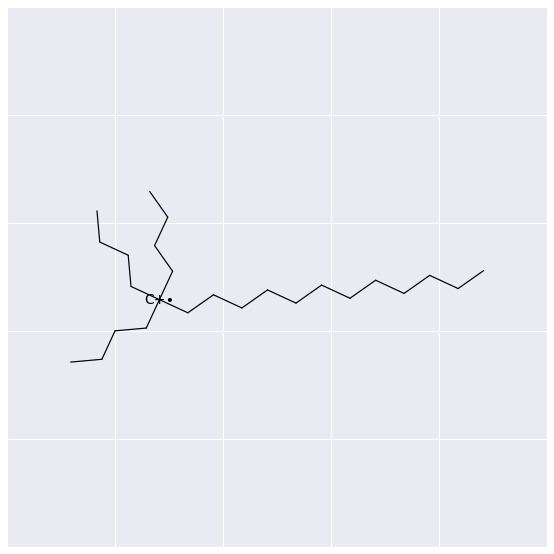

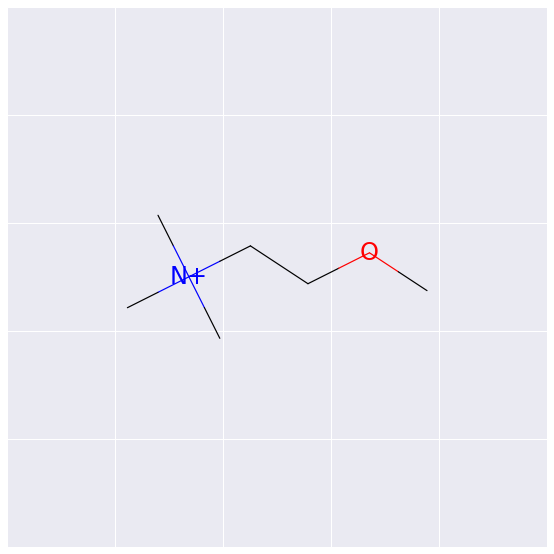

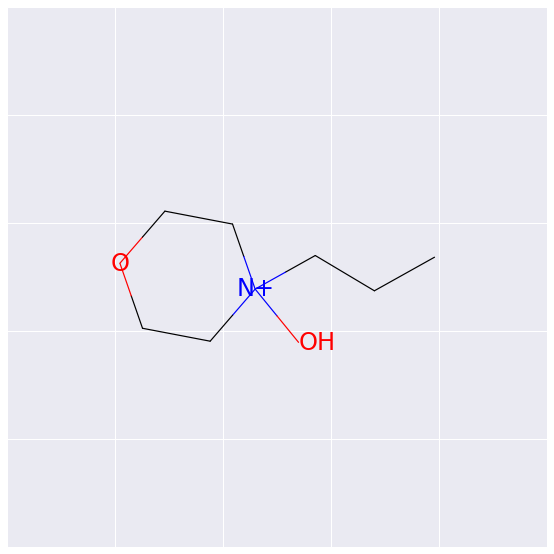

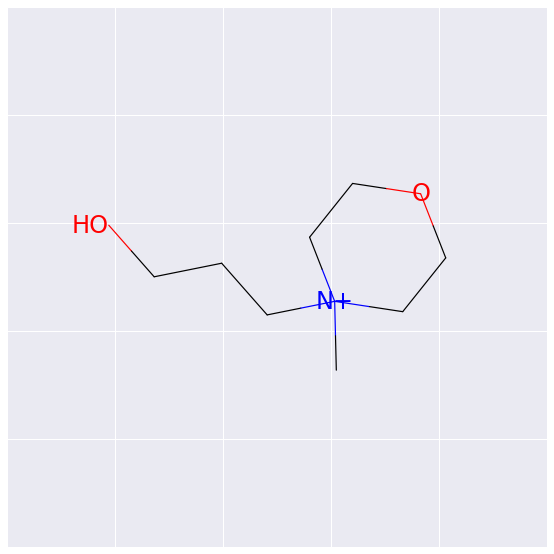

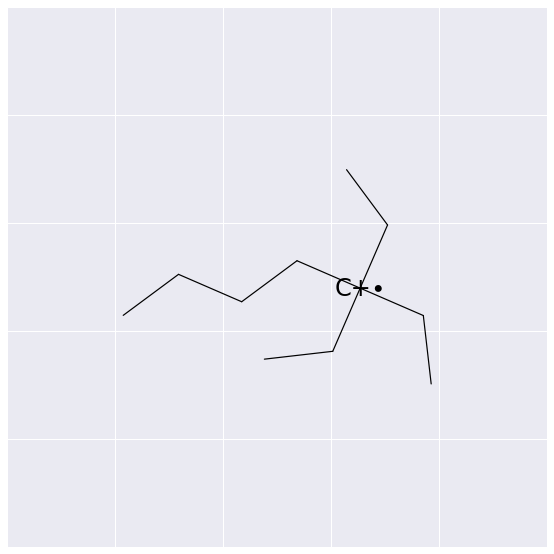

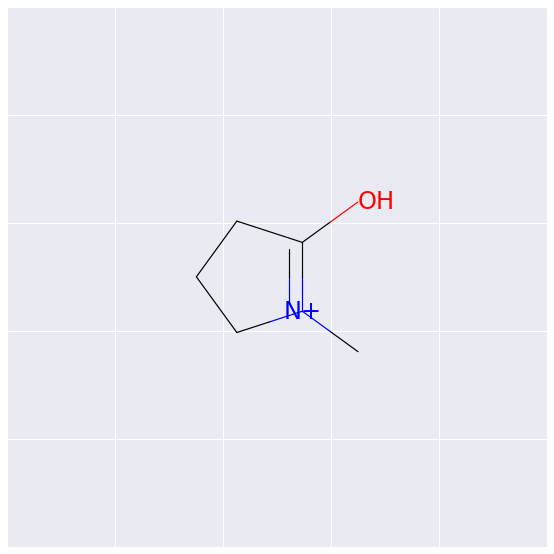

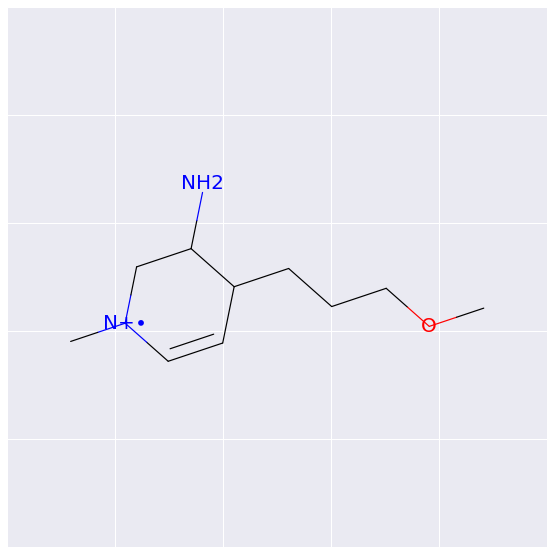

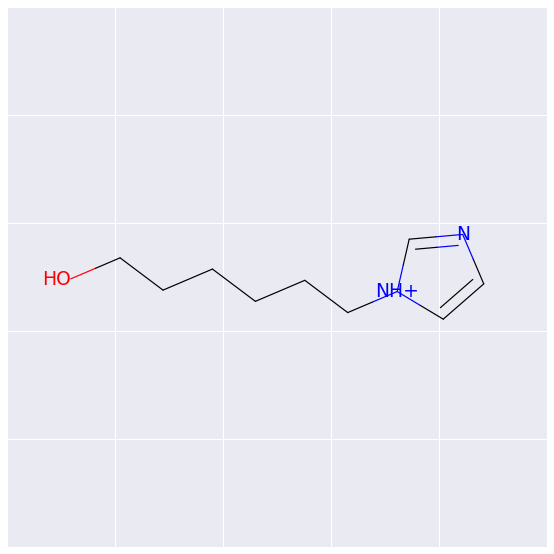

In [375]:
for item in rdkit_mols:
    vae_cat = Chem.MolFromSmiles(item)
    img = Draw.MolToMPL(vae_cat)
    score, index = get_sim(vae_cat)
    print(score)
    img2 = Draw.MolToMPL(Chem.MolFromSmiles(cations[index]))
#     if score < .9:
#         break

[N+](CCC(CC)(C)(CCC))C                             
CC[N+](CC)(CC)CCCCCCCC                             
CC1cC[n+](c1)CCCCCCCC                              
CCCCCCC(=C)CC1CCCCOOOC1            N               
C1=C[N+](CCC#C)=CN1CCCCCC                          
Cc1cc([n+](C1c2ccccc2)C)C                          
CCCCCC[C+](CCCCCO)(CCCCCC)CCCCCCC                  
C#CCCC1cc[C+](c1)CCN                               
CCCCCCC[n+]1cc[C](c1)CC                            
CCCCCCC[n+]1cc(C)ccc1                              
CCCCCC[n+]1cccc(C#N)c1                             
C1=C[N+](CCCC)=NN1C                                
CCNC[P+](CCCC)(CCCC)CCCC                           
CC1cc[C+](C1C)CCCCC                                
CCCCCCCCCCC[n+]1ccC(c1)C                           
CCCCC2CCCCC2CC[N+](CC)(CC)CC                       
[P+](CC)(CC)CCCC(CCCCCC)                           
C[N+]1(CCCC1)CC(C)(C)                              
C[N+]1(CCCCC1)CCO                                  
[P+](CC)(CO)

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CC[C+](CC)(CC)CCCC                                 
C1=C[N+](C)CC(N)C1CCCOC                            


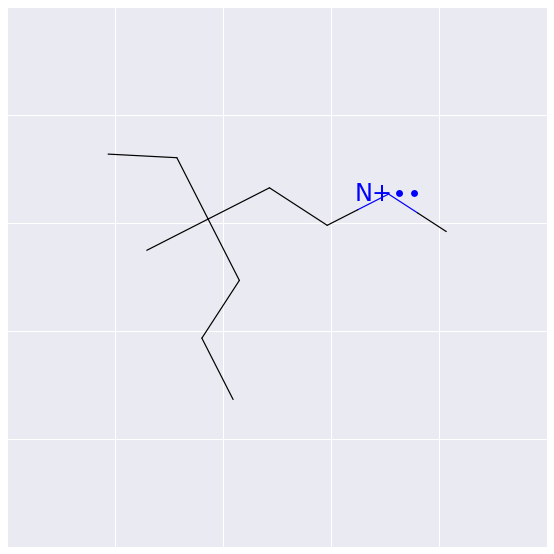

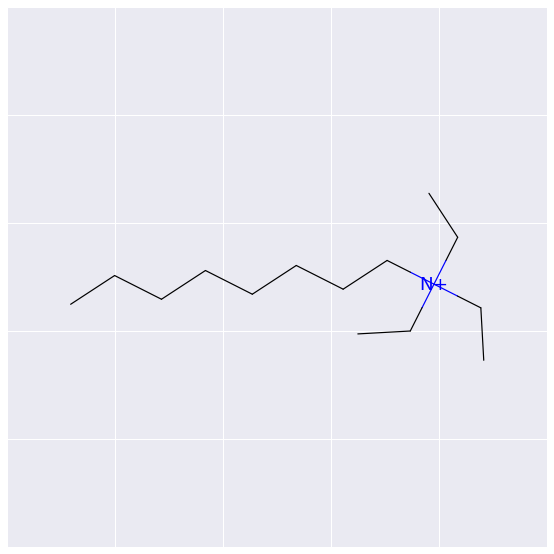

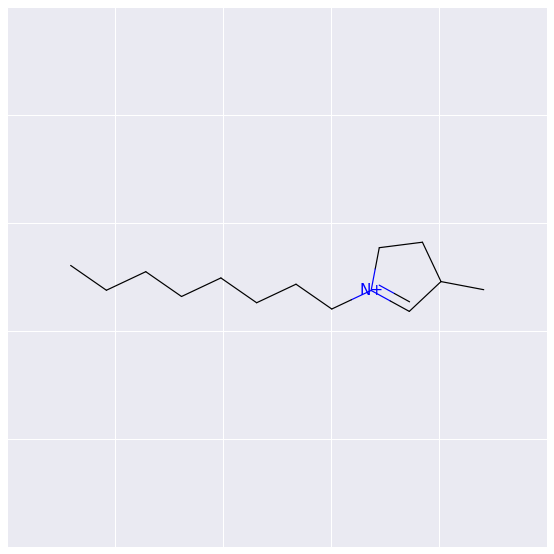

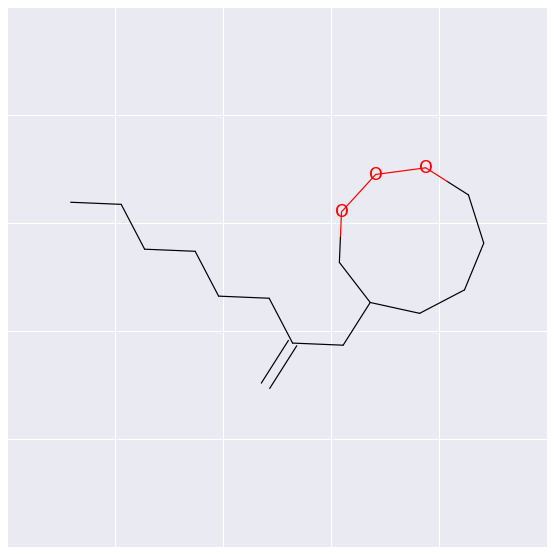

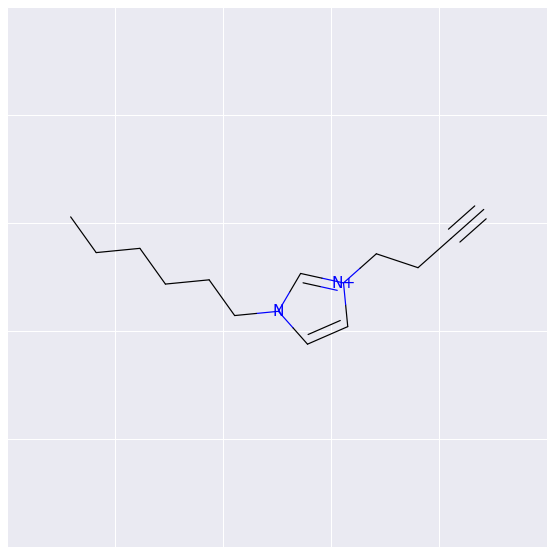

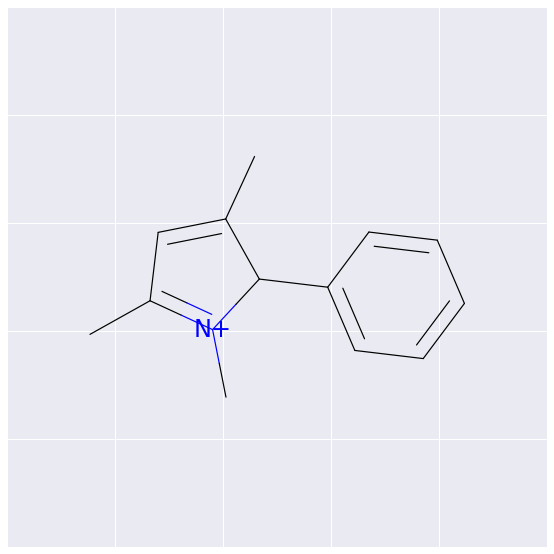

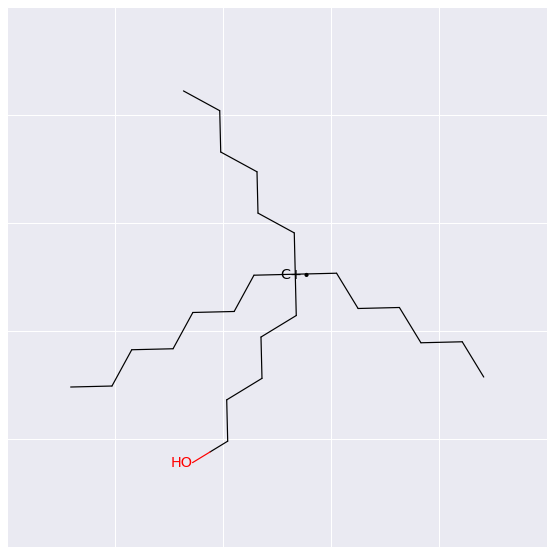

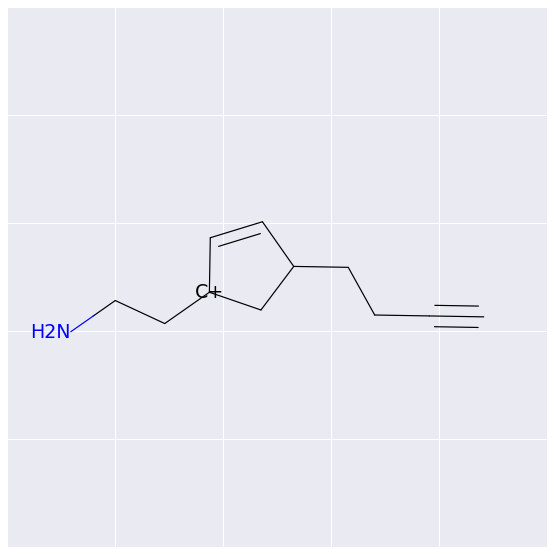

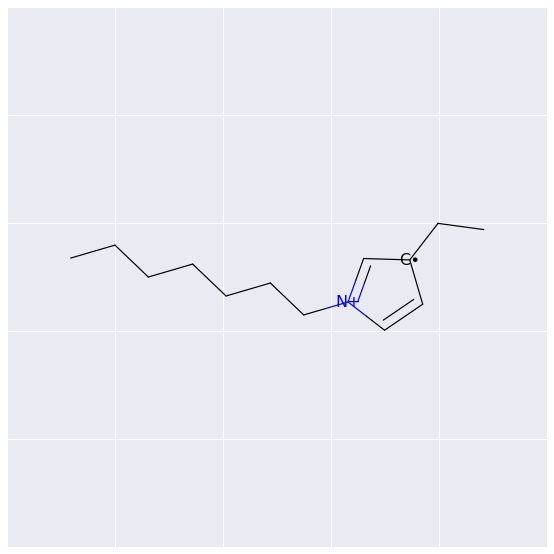

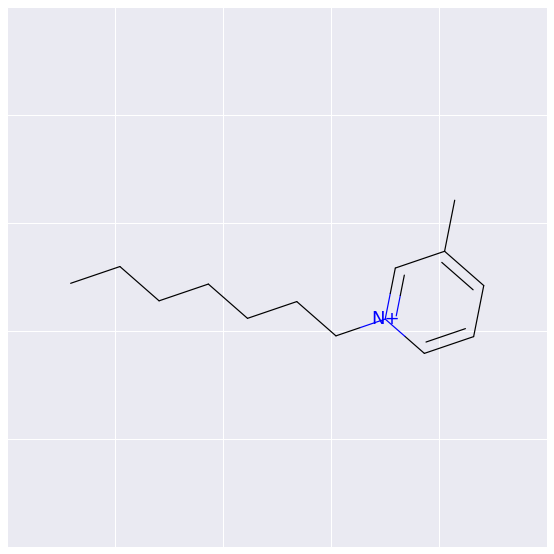

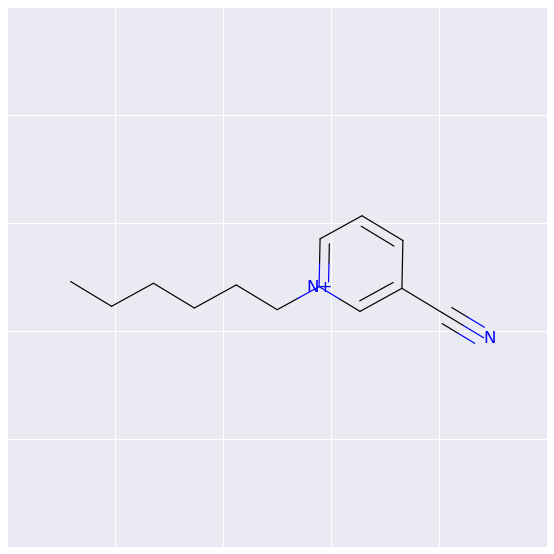

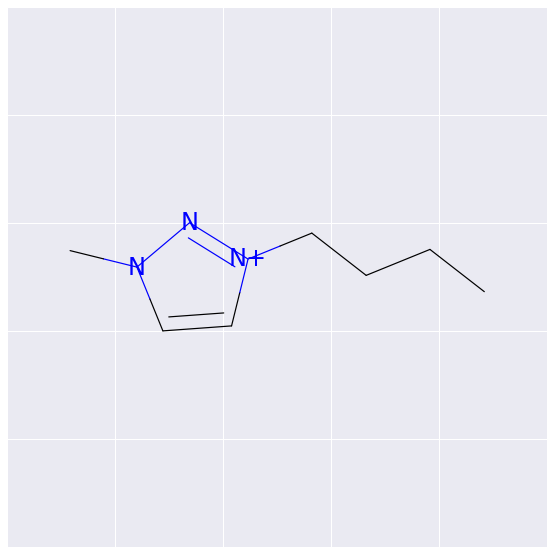

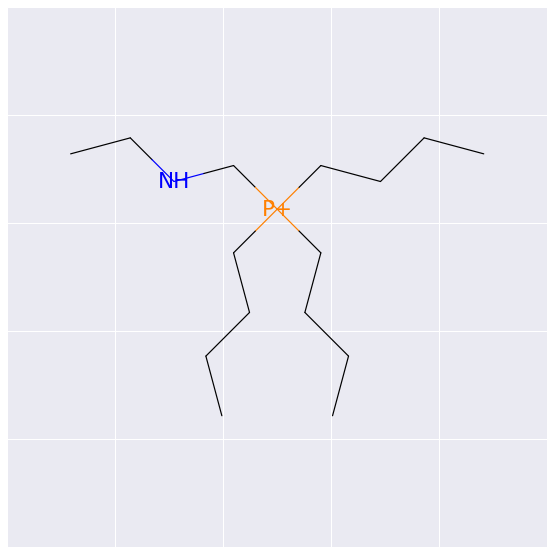

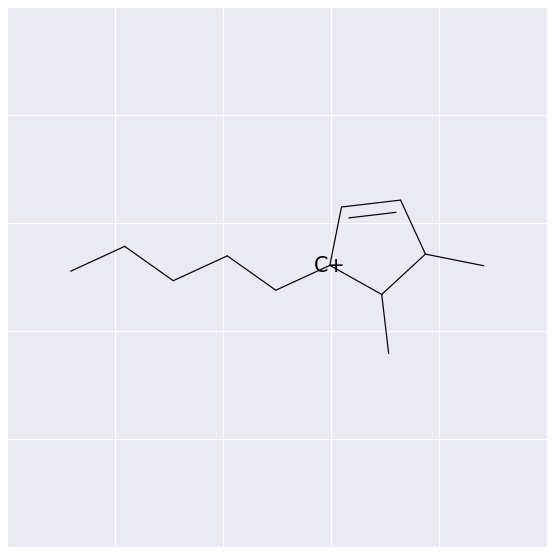

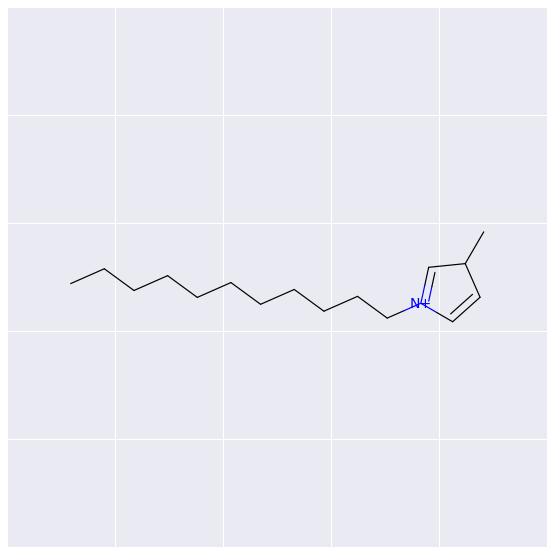

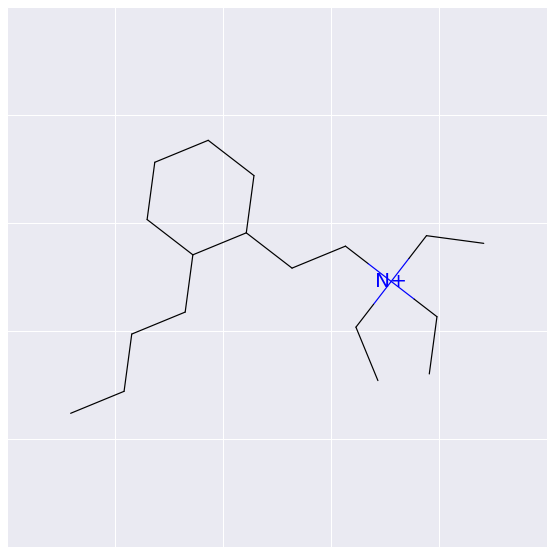

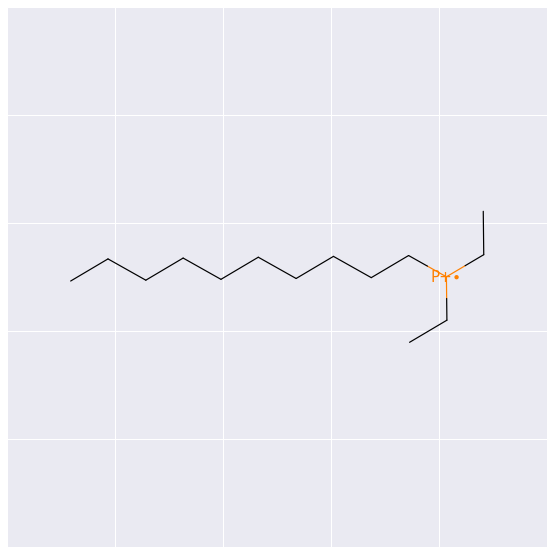

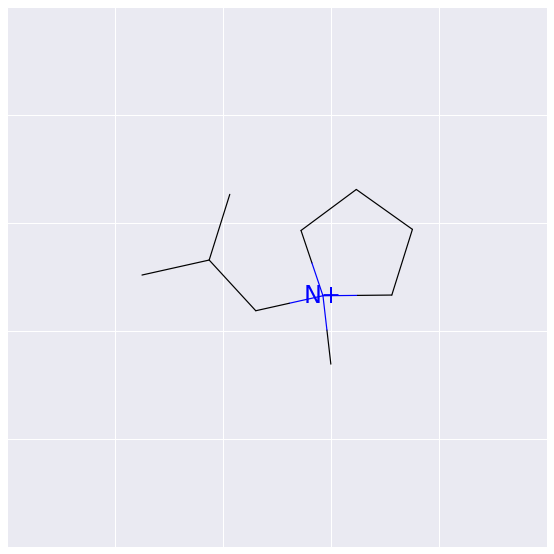

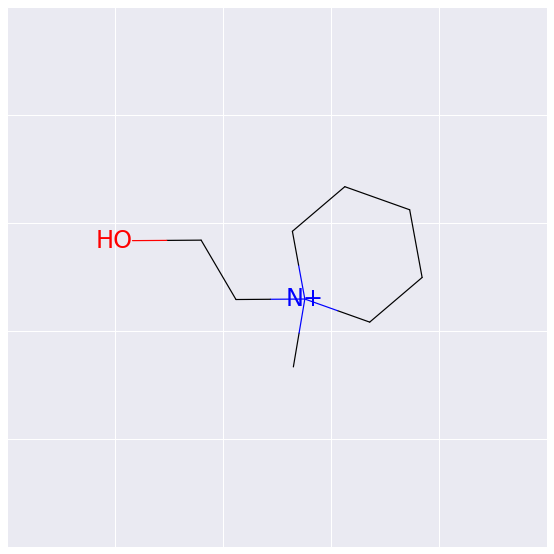

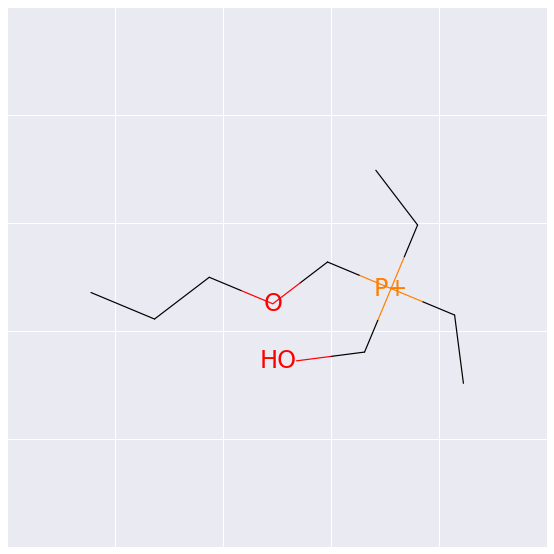

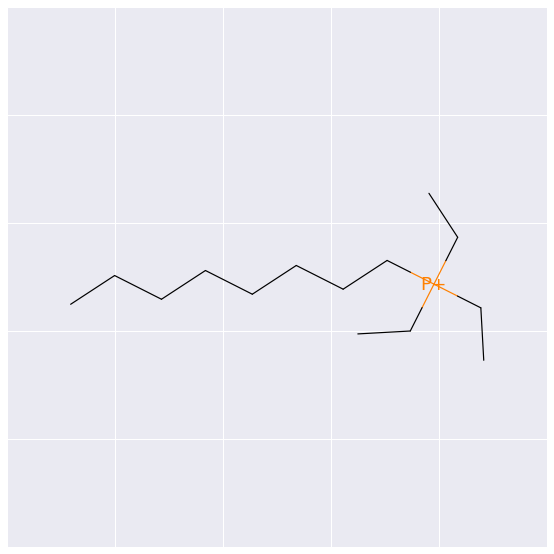

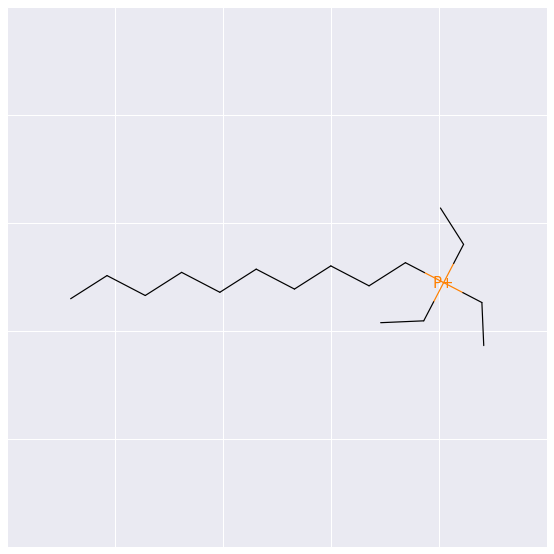

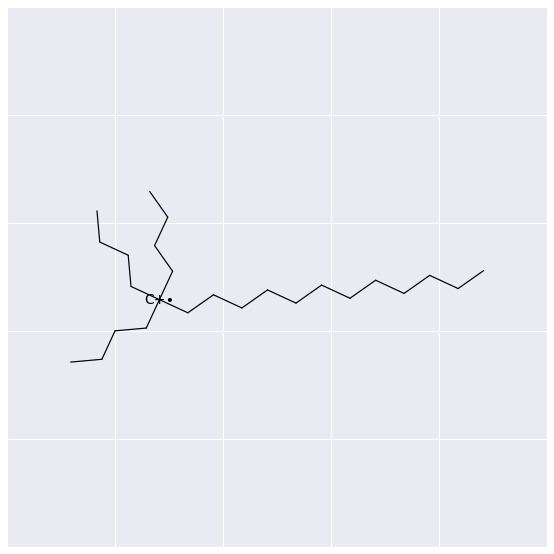

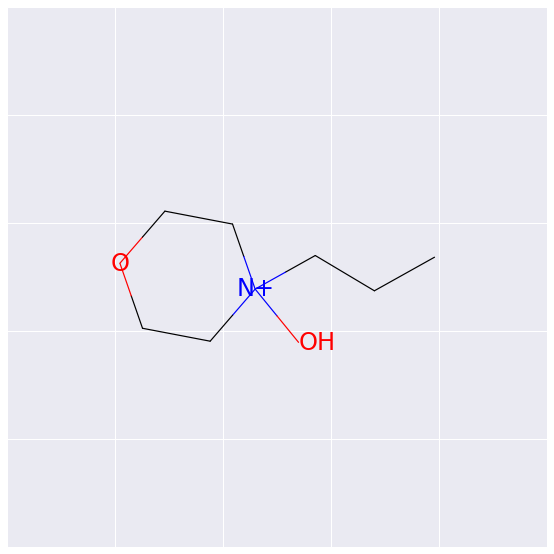

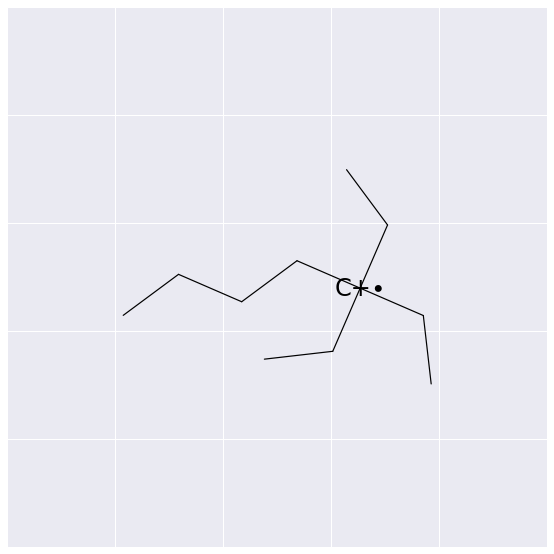

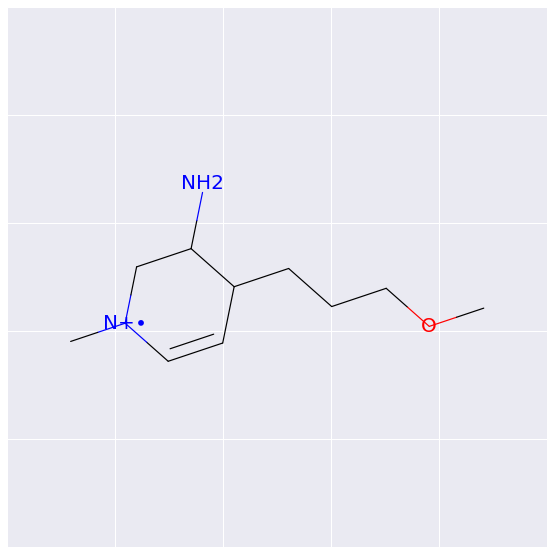

In [376]:
% matplotlib inline
rdkit_mols=[]
for smi in cation_samples:
    try:
        sampled = Chem.MolFromSmiles(smi)
        Draw.MolToMPL(sampled)
        rdkit_mols.append(smi)
        print(smi)
    except:
        pass